In [49]:
%matplotlib inline

In [50]:
from __future__ import absolute_import, division, print_function

from collections import Iterable, MutableMapping, OrderedDict
from copy import deepcopy
from glob import glob
import multiprocessing
import os
from os import makedirs
from os.path import abspath, basename, expanduser, expandvars, join, isdir, isfile
import pickle
import sys
import time
import warnings

from IPython.display import display, Image

import numba
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
import pandas as pd
from scipy import interpolate, optimize, stats

os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())

from pisa.utils.log import set_verbosity
set_verbosity(0)
from pisa.utils.vbwkde import vbwkde

RETRO_DIR = abspath('..')
sys.path.append(RETRO_DIR)
from retro.retro_types import FitStatus
from retro.utils.stats import weighted_percentile, fit_cdf
from retro.utils.fit_prior_dist import TRUTH_FNAME, RECOS_FNAME, RECO_PERF_FNAME, PARAMS, RECOS, extract, fit_distributions_to_data
from retro.utils.geom import rotate_points
from retro.utils.weight_diff_tails import weight_diff_tails
from retro.utils.lerp import generate_lerp
from retro.utils.prior_from_reco import prior_from_reco

In [47]:
outdir = '~/extract'
outdir = expanduser(expandvars(outdir))

Note that all recos tested / extracted for this study are:

```
CascadeLast_DC DipoleFit_DC FiniteRecoFit L4_ToI L4_ToIEval2 L4_ToIEval3 L4_iLineFit L5_SPEFit11
LineFit LineFit_DC MM_DC_LineFitI_MM_DC_Pulses_1P_C05 MM_IC_LineFitI MPEFit MPEFitMuEX
PoleMuonLinefit PoleMuonLlhFit SPEFit2 SPEFit2MuEX_FSS SPEFit2_DC SPEFitSingle SPEFitSingle_DC ToI_DC
```

In [6]:
def azerr(reco, true):
    return ((reco - true + np.pi) % (2*np.pi)) - np.pi

In [7]:
def plot_dists(reco_perf, truth, recos, outbase=None, plot_reco_names=None, params=('x', 'y', 'z', 'time'), outdir=outdir):
    xlim = dict(
        x=(-250, 250),
        y=(-250, 250),
        z=(-200, 200),
        time=(-1000, 1000),
    )

    if plot_reco_names is None:
        plot_reco_names = sorted(reco_perf.reco.unique())
    
    outdir = expanduser(expandvars(outdir))

    nr = len(plot_reco_names)
    fig, axes = plt.subplots(nr, 4, dpi=72, figsize=(20, 3*nr))
    axiter = iter(axes.flat)

    for reco_name in plot_reco_names:
        reco_vals = recos[reco_name]
        for param in params:
            try:
                err = reco_vals[param] - truth[param]
                mask = np.isfinite(err) & (reco_vals['fit_status'] == FitStatus.OK)
                valid_err = err[mask]

                ax = axiter.next()
                xl = xlim[param]
                bins = np.linspace(xl[0], xl[1], 100)
                ax.hist(valid_err, bins=bins, weights=truth['weight'][mask], density=True, label='weighted')
                ax.hist(valid_err, bins=bins, weights=None, density=True, histtype='step', label='unweighted')
                ax.set_xlim(xl)
                ax.set_yticks([])
                ax.legend(loc='upper right', frameon=False)

                info = reco_perf.query('(reco == @reco_name) & (param == @param)')
                info_d = dict(zip(info.columns, info.values[0]))
                label = '\n'.join([
                    'Invalid: {n_invalid:-5d}',
                    'Mean   : {err_mean:+8.2f}',
                    'Median : {err_median:+8.2f}',
                    'IQ50%  : {err_iq50:+8.2f}',
                    'IQ90%  : {err_iq90:+8.2f}',
                ]).format(**info_d)
                ax.add_artist(
                    AnchoredText(label, loc='center left', prop=dict(size=10, family='monospace'), frameon=False)
                )
                label = '{reco}\n{param}'.format(**info_d)
                ax.add_artist(
                    AnchoredText(label, loc='upper left', prop=dict(size=12, family='monospace', horizontalalignment='left'), frameon=False)
                )
            except:
                print('ERROR! ->', reco_name, param)
                raise
            reco_perf.append(info)

    fig.tight_layout()
    
    if outdir is not None and outbase is not None:
        fbase = join(outdir, outbase)
        fig.savefig(fbase + '.png', dpi=120)
        fig.savefig(fbase + '.pdf')

    return axes

In [45]:
TRUTH_FNAME

'truth.pkl'

In [46]:
outdir

'/home/justin/extract'

In [8]:
%%time

try:
    truth = pickle.load(open(join(outdir, TRUTH_FNAME), 'rb'))
    recos = pickle.load(open(join(outdir, RECOS_FNAME), 'rb'))
    reco_perf = pickle.load(open(join(outdir, RECO_PERF_FNAME), 'rb'))
except:
    print('failed...')
    reco_perf, recos, truth = extract(outdir=outdir)

CPU times: user 8 ms, sys: 372 ms, total: 380 ms
Wall time: 381 ms


In [8]:
np.nanmin(recos['L5_SPEFit11']['azimuth']), np.nanmax(recos['L5_SPEFit11']['azimuth'])

(2.660796e-08, 6.2831826)

In [9]:
reco_perf.head(12)

reco param  n_invalid    err_mean  err_median      err_min  \
3   CascadeLast_DC  time          0 -155.879974  -48.015280 -9484.270508   
0   CascadeLast_DC     x          0    0.604676    0.295388  -830.908325   
1   CascadeLast_DC     y          0   -1.391772   -0.873370  -790.823059   
2   CascadeLast_DC     z          0   21.346725   12.962836  -451.939148   
7     DipoleFit_DC  time       8223  667.061523  621.692122 -1237.111328   
4     DipoleFit_DC     x       8223    0.803873    0.408739  -787.704285   
5     DipoleFit_DC     y       8223   -1.749155   -1.276780  -717.586487   
6     DipoleFit_DC     z       8223   22.695086   15.228482  -447.082031   
11     L4_ToIEval2  time          0  612.447449  560.909655 -2143.376953   
8      L4_ToIEval2     x          0    0.604676    0.295388  -830.908325   
9      L4_ToIEval2     y          0   -1.391772   -0.873370  -790.823059   
10     L4_ToIEval2     z          0   21.346725   12.962836  -451.939148   

        err_max    err_iq50     err_iq90  err_absmean  err_absmedian  \
3   3876.533691  238.125067  1263.370647   155.879974      48.015280   
0    744.155518   48.882380   165.795337     0.604676       0.295388   
1    732.180054   49.124357   164.613837     1.391772       0.873370   
2    941.441406   35.555979   135.172779    21.346725      12.962836   
7   3883.161133  385.844772  1002.951534   667.061523     621.692122   
4    742.925842   54.122698   171.124673     0.803873       0.408739   
5    706.941345   53.582206   169.572522     1.749155       1.276780   
6    814.142456   40.457405   139.363052    22.695086      15.228482   
11  5350.260742  404.274307  1048.659835   612.447449     560.909655   
8    744.155518   48.882380   165.795337     0.604676       0.295388   
9    732.180054   49.124357   164.613837     1.391772       0.873370   
10   941.441406   35.555979   135.172779    21.346725      12.962836   

     err_absmin   err_absmax  
3   9484.270508  3876.533691  
0    830.908325   744.155518  
1    790.823059   732.180054  
2    451.939148   941.441406  
7   1237.111328  3883.161133  
4    787.704285   742.925842  
5    717.586487   706.941345  
6    447.082031   814.142456  
11  2143.376953  5350.260742  
8    830.908325   744.155518  
9    790.823059   732.180054  
10   451.939148   941.441406

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/matplotlib/offsetbox.py:1259: UserWarning: Mixing horizontalalignment or verticalalignment with AnchoredText is not supported.
  warnings.warn("Mixing horizontalalignment or verticalalignment "



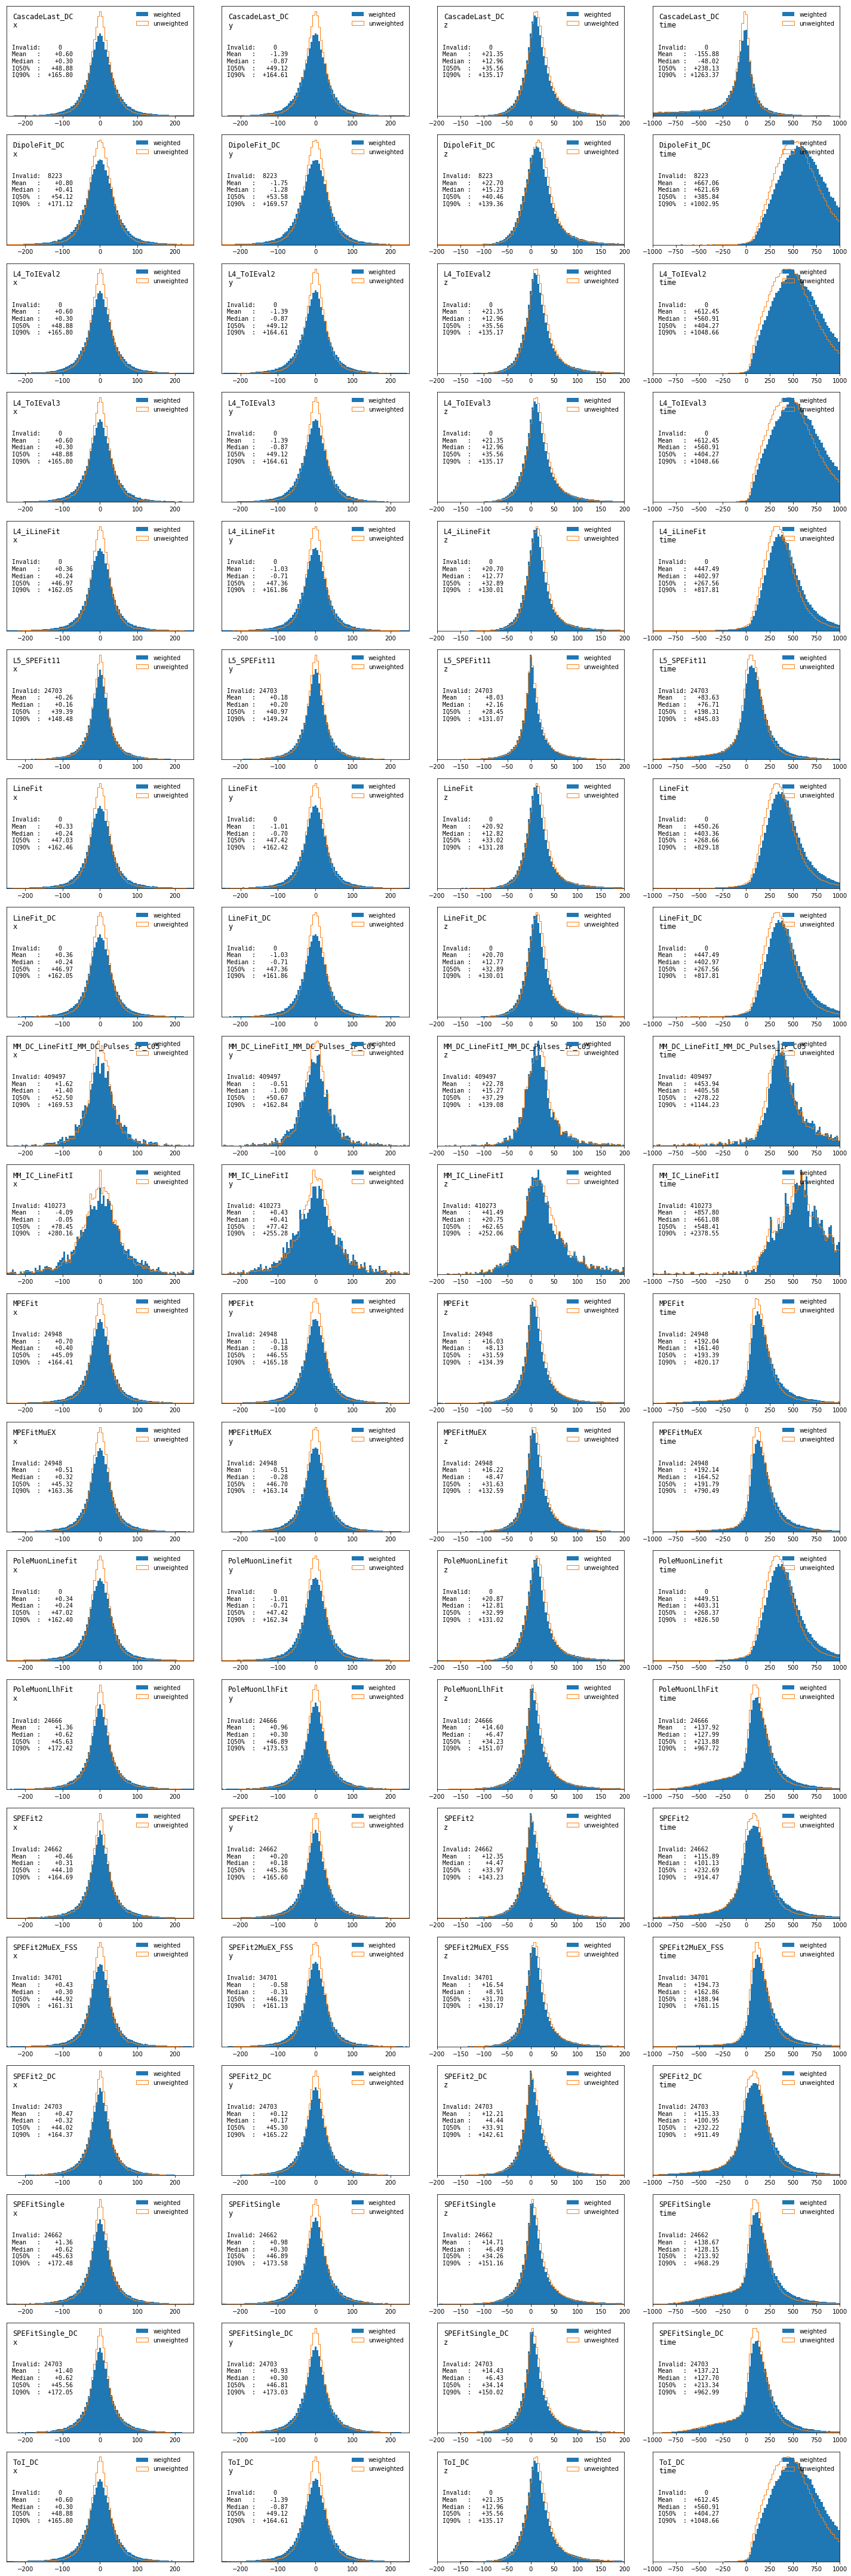

In [10]:
ax = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, outdir=outdir, outbase='err_dist_by_reco')

In [11]:
medians = reco_perf.groupby('param').quantile(0.5)
medians

0.5     err_absmax  err_absmean  err_absmedian   err_absmin    err_iq50  \
param                                                                     
time   6702.637695   321.111488     283.747529  3329.264160  252.840429   
x       762.277222     0.604676       0.297079   875.081665   46.974263   
y       789.750061     0.971089       0.555057   796.003021   47.359179   
z       959.207703    20.696405      12.772276   451.939148   34.051361   

0.5      err_iq90      err_max    err_mean  err_median      err_min  n_invalid  
param                                                                           
time   938.730707  6702.637695  321.111488  283.747529 -3329.264160    24662.0  
x      165.242309   762.277222    0.557513    0.297079  -875.081665    24662.0  
y      164.613837   789.750061   -0.547327   -0.503640  -796.003021    24662.0  
z      135.172779   959.207703   20.696405   12.772276  -451.939148    24662.0

no invalid reos: ['CascadeLast_DC', 'L4_ToIEval2', 'L4_ToIEval3', 'L4_iLineFit', 'LineFit', 'LineFit_DC', 'PoleMuonLinefit', 'ToI_DC']
best recos by ['err_iq50', 'err_iq90']: ['L5_SPEFit11', 'MPEFitMuEX', 'SPEFit2MuEX_FSS']
both good fits and no invalid: set([])
best no-invlid reccos by ['err_iq50', 'err_iq90']: ['L4_iLineFit', 'LineFit_DC', 'PoleMuonLinefit']
recos to compare: ['L5_SPEFit11', 'MPEFitMuEX', 'SPEFit2MuEX_FSS', 'L4_iLineFit', 'LineFit_DC', 'PoleMuonLinefit']


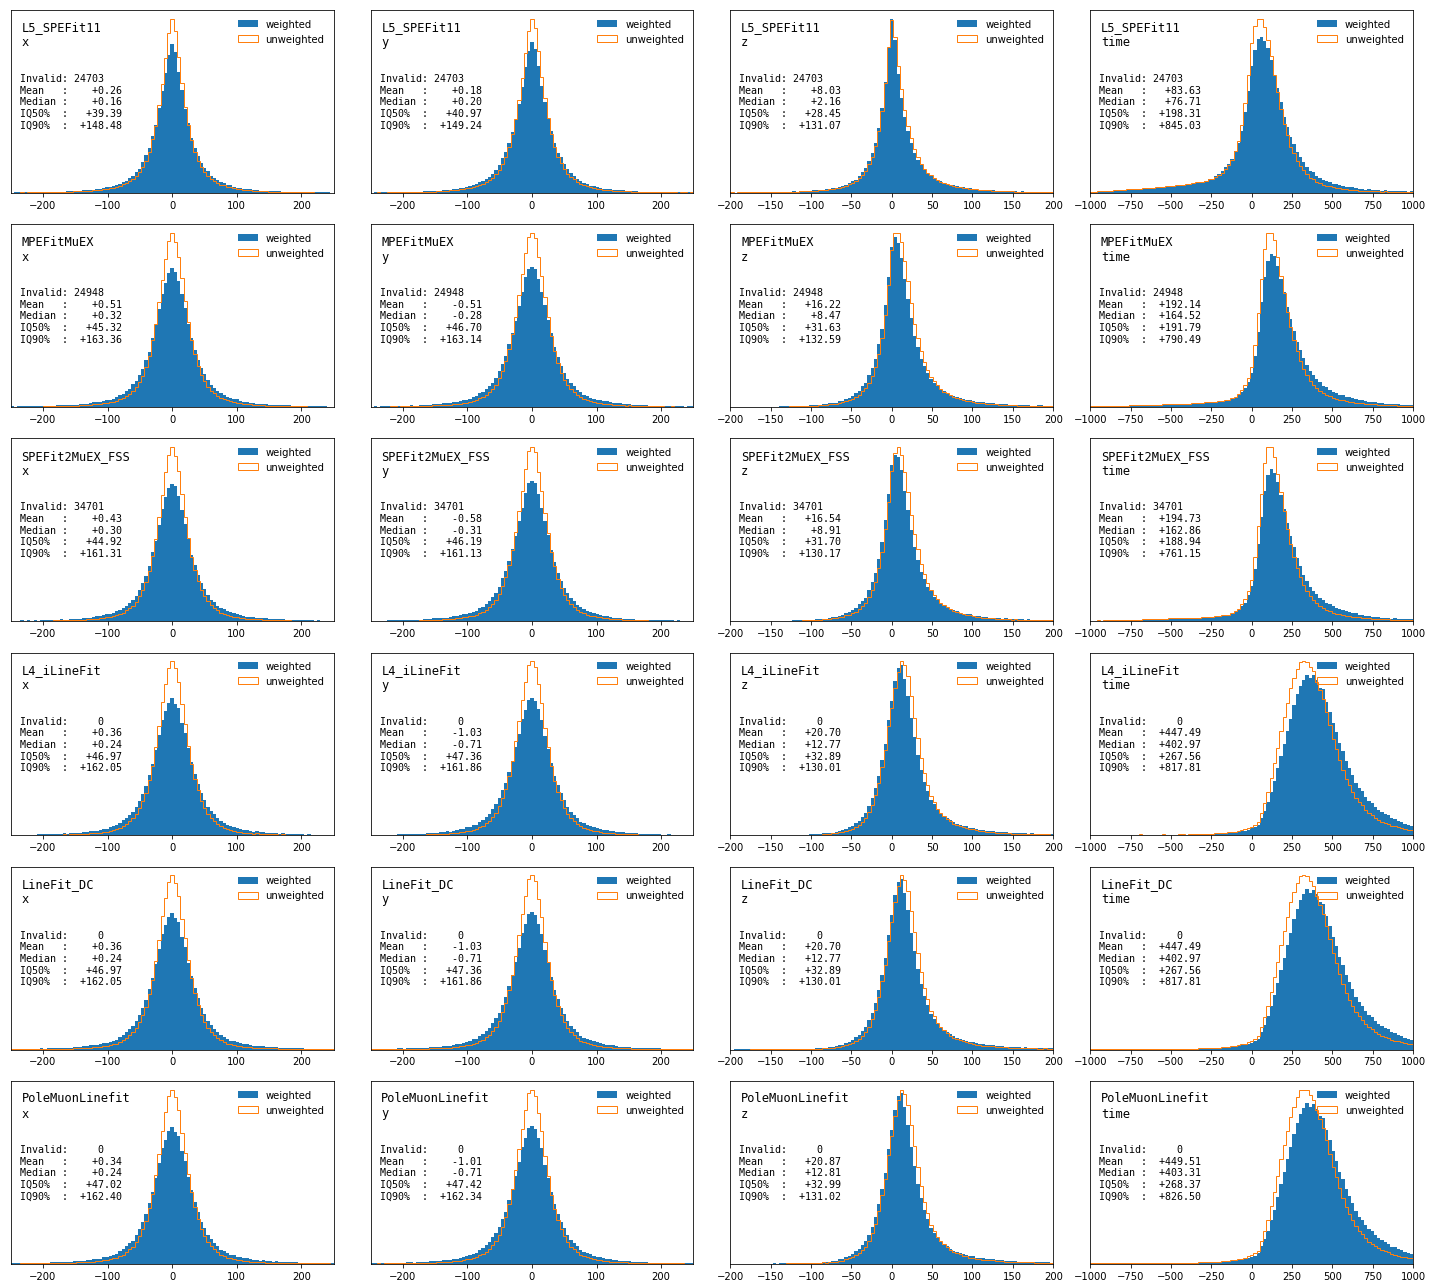

In [12]:
medians = reco_perf.groupby('param').quantile(0.5)

bad_fits = set()
no_invalid = set()
param_names = medians.index.values
compare_cols = ['err_iq50', 'err_iq90']
for idx, grp in reco_perf.groupby('reco'):
    include = True
    for param in param_names:
        if np.all(grp['n_invalid'] == 0):
            no_invalid.add(idx)
        if np.sum(grp.query('param == @param')[compare_cols].values > medians.loc[param][compare_cols].values) > 0:
            bad_fits.add(idx)
best = set([r for r in RECOS if r not in bad_fits])
best_and_no_invalid = best.intersection(no_invalid)
print('no invalid reos:', sorted(no_invalid))
print('best recos by {}: {}'.format(compare_cols, sorted(best)))
print('both good fits and no invalid: {}'.format(best_and_no_invalid))


infos_no_invalid = reco_perf.query('reco in @no_invalid')
medians_no_invalid = infos_no_invalid.groupby('param').quantile(0.5)
bad_fits_no_invalid = set()
param_names = medians_no_invalid.index.values
compare_cols = ['err_iq50', 'err_iq90']
for idx, grp in infos_no_invalid.groupby('reco'):
    for param in param_names:
        if np.sum(grp.query('param == @param')[compare_cols].values > medians_no_invalid.loc[param][compare_cols].values) > 0:
            bad_fits_no_invalid.add(idx)
best_of_no_invalid = set([r for r in infos_no_invalid['reco'].unique() if r not in bad_fits_no_invalid])
print('best no-invlid reccos by {}: {}'.format(compare_cols, sorted(best_of_no_invalid)))

remaining = sorted(best) + sorted([r for r in best_of_no_invalid if r not in best])
print('recos to compare:', remaining)

ax = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, plot_reco_names=remaining, outbase='err_dist_by_reco_best')

In [13]:
failed_spe11 = recos['L5_SPEFit11']['fit_status'] != FitStatus.OK
failed_spemuex = recos['SPEFit2MuEX_FSS']['fit_status'] != FitStatus.OK

In [14]:
print(np.sum(failed_spe11), np.sum(failed_spemuex))
print(np.sum(failed_spe11 == failed_spemuex), np.sum(failed_spe11 != failed_spemuex))
print(np.sum(failed_spe11 & np.logical_not(failed_spemuex)))
print(np.sum(failed_spemuex & np.logical_not(failed_spe11)))

24703 34701
405160 10102
52
10050


Based on the above, we will choose to use **L5_SPEFit11** for first shot and if that is a failed reco, fall back on **LineFit_DC**.

In [15]:
CHOSEN_RECOS = ('L5_SPEFit11', 'LineFit_DC')

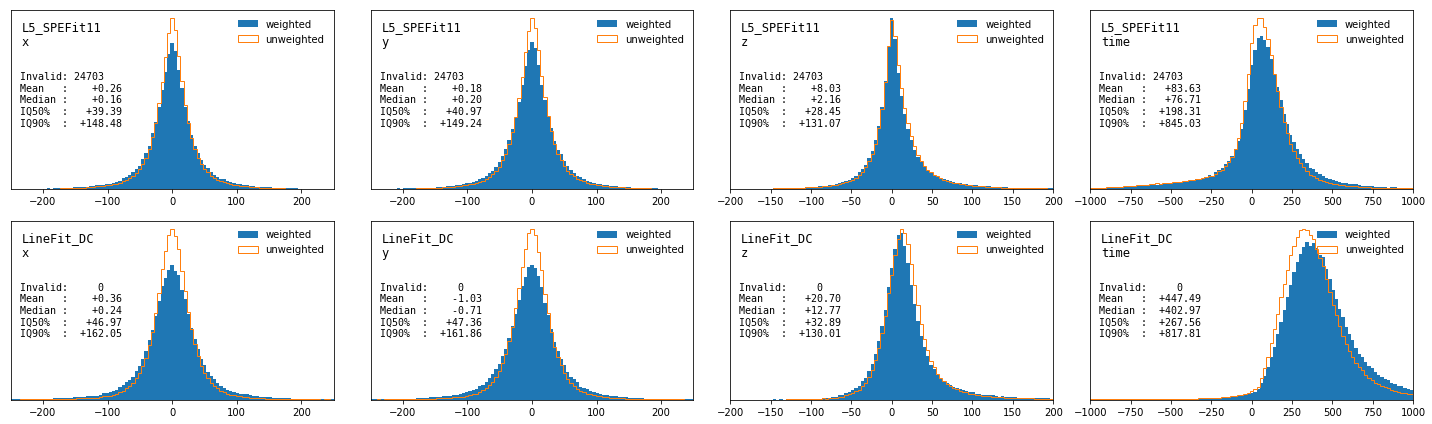

In [16]:
axes = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, plot_reco_names=CHOSEN_RECOS, outbase='err_dist_by_reco_chosen')

# Fitting the distributions

In [17]:
ls ~/extract/*pkl

/home/justin/extract/azerr_dists.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=coszen__dist=johnsonsb.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time__dists_sha256=44fcc6564d.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time__dists_sha256=4e967b517d.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=56519c0fdd.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=63e9fcd035.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=9b33da3caf.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=c48e7eef1e.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=e3b98a4da3.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=x__dists_sha256=017f667d44.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=x__dists_sha256=44fcc6564d.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit1

In [18]:
dists_sha256 = '44fcc6564d'
all_recos_fits = OrderedDict()
for reco in CHOSEN_RECOS:
    reco_fits = {}
    for f in glob(join(outdir, 'fit_info__reco={}__*__dists_sha256={}.pkl'.format(reco, dists_sha256))):
        tmp = pickle.load(open(f, 'rb'))
        reco_fits.update(tmp)

    tmp = OrderedDict()
    for k in sorted(reco_fits.keys()):
        tmp[k] = reco_fits[k]
    reco_fits = tmp

    all_recos_fits[reco] = reco_fits

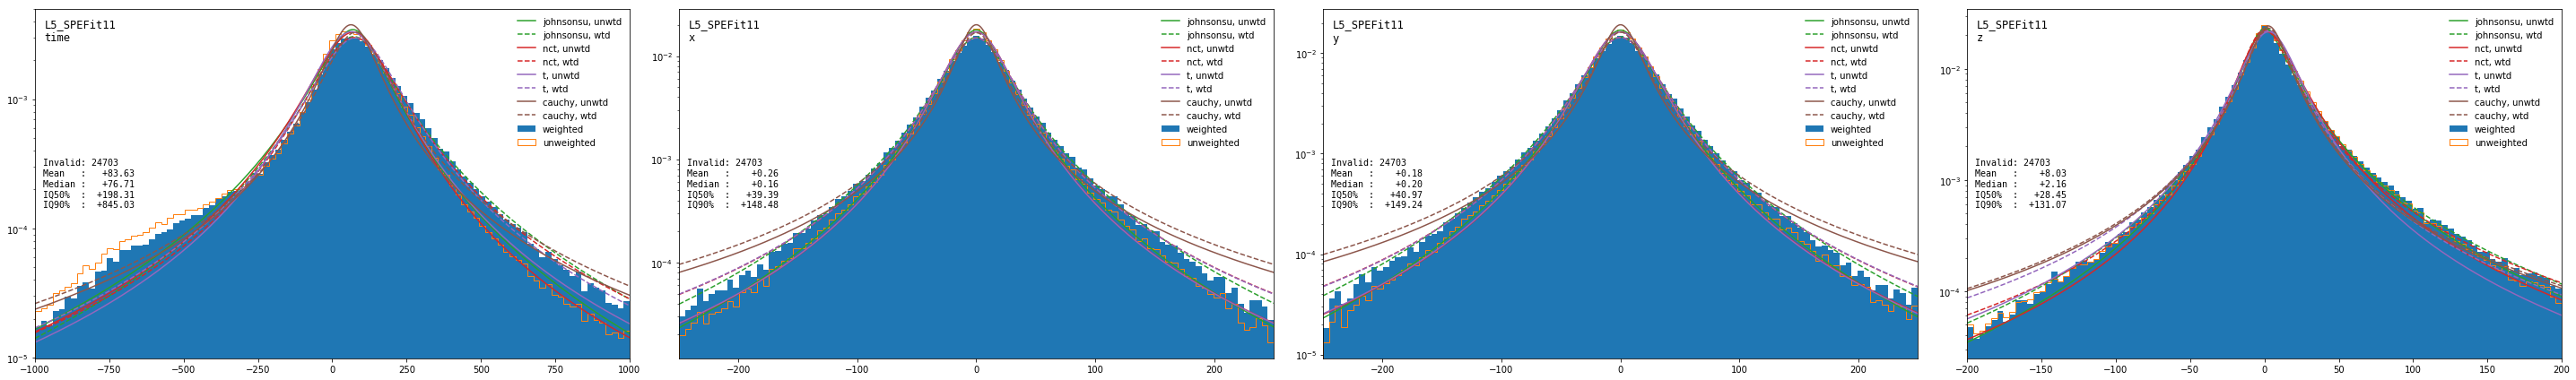

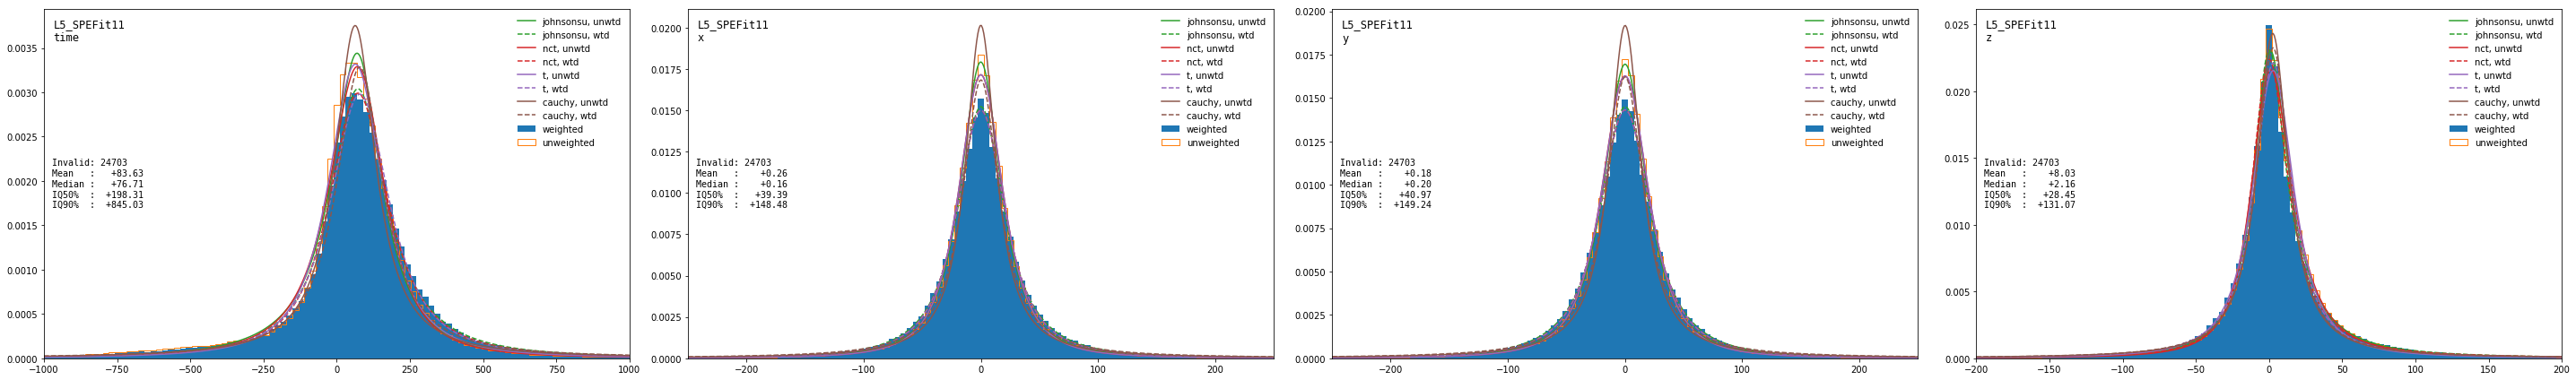

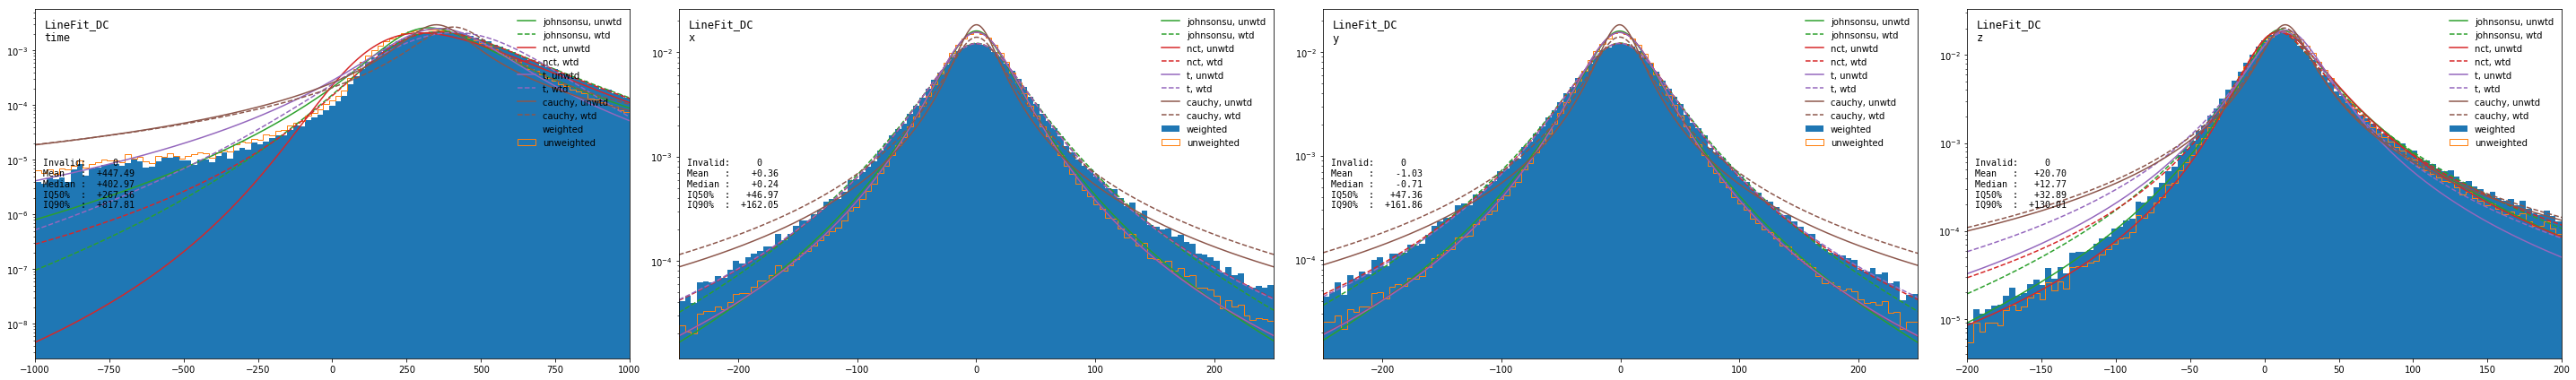

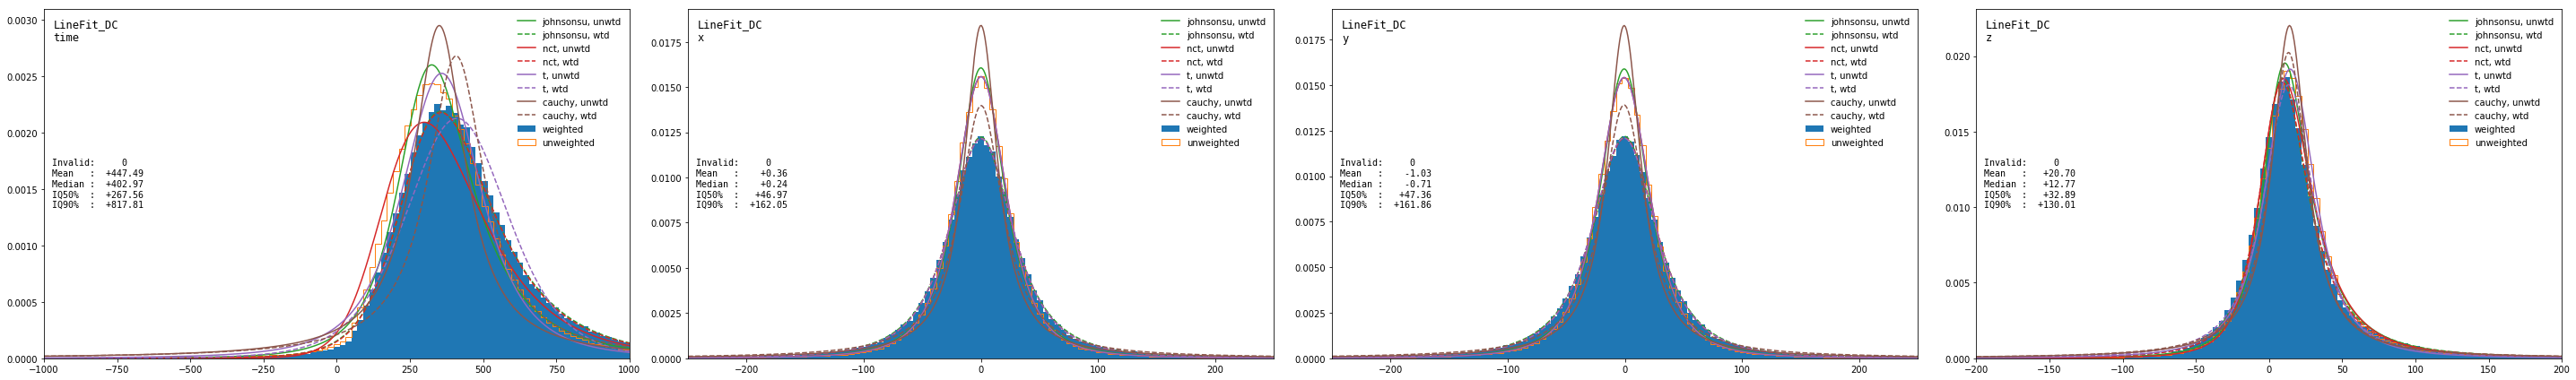

In [19]:
for reco, reco_fits in all_recos_fits.items():
    for yscale in ['log', 'linear']:
        n_params = len(reco_fits)
        axes = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, plot_reco_names=[reco], params=reco_fits.keys())
        axit = iter(axes)
        for ax, (param, dist_fits) in zip(axes, reco_fits.items()):
            ax.set_yscale(yscale)
            for dist_name, fits in dist_fits.items():
                xlim = ax.get_xlim()
                x = np.linspace(xlim[0], xlim[1], 500)
                dist = getattr(stats.distributions, dist_name)
                pdf_unwtd = dist.pdf(x, **fits['first_guess_params'])
                pdf_wtd = dist.pdf(x, **fits['best_fit_params'])
                lines = ax.plot(x, pdf_unwtd, label='{}, unwtd'.format(dist_name))
                color = lines[0].get_color()
                ax.plot(x, pdf_wtd, label='{}, wtd'.format(dist_name), color=color, ls='--')
                ax.legend(loc='upper right', frameon=False, )
        fig = ax.get_figure()
        fig.set_figheight(fig.get_figheight()*2)
        fig.set_figwidth(fig.get_figwidth()*2)
        fig.tight_layout()
        basefpath = join(outdir, 'plot_dist_fits_{}_{}'.format(reco, yscale))
        fig.savefig(basefpath + '.pdf')
        fig.savefig(basefpath + '.png', dpi=120)

Based on the above, we are choosing:

**L5_SPEFit11**
* time : t wtd
* x : t wtd
* y : t wtd
* z : johnsonsu wtd

**LineFit_DC**
* time : cauchy wtd
* x : t wtd
* y : t wtd
* z : johnsonsu wtd

In [20]:
CHOSEN_DISTS = OrderedDict()

CHOSEN_DISTS['L5_SPEFit11'] = OrderedDict([('time', 't wtd'), ('x', 't wtd'), ('y', 't wtd'), ('z', 'johnsonsu wtd')])
CHOSEN_DISTS['LineFit_DC'] = OrderedDict([('time', 'cauchy wtd'), ('x', 't wtd'), ('y', 't wtd'), ('z', 'johnsonsu wtd')])
CHOSEN_DISTS

OrderedDict([('L5_SPEFit11',
              OrderedDict([('time', 't wtd'),
                           ('x', 't wtd'),
                           ('y', 't wtd'),
                           ('z', 'johnsonsu wtd')])),
             ('LineFit_DC',
              OrderedDict([('time', 'cauchy wtd'),
                           ('x', 't wtd'),
                           ('y', 't wtd'),
                           ('z', 'johnsonsu wtd')]))])

In [21]:
priors = OrderedDict()

for reco in CHOSEN_RECOS:
    for param in PARAMS:
        try:
            dist_name, wtd_or_not = CHOSEN_DISTS[reco][param].split()
        except KeyError:
            continue
        if wtd_or_not == 'wtd':
            pfx = 'best_fit'
        elif wtd_or_not == 'unwtd':
            pfx = 'first_guess'
        else:
            raise ValueError(str(wtd_or_not))
        print(reco, param)
        print('dist = "{}"'.format(dist_name))
        print('params =', all_recos_fits[reco][param][dist_name]['{}_params'.format(pfx)])
        print('')

L5_SPEFit11 x
dist = "t"
params = OrderedDict([('df', 1.6867177062057637), ('loc', 0.14572812956903736), ('scale', 23.08818410937512)])

L5_SPEFit11 y
dist = "t"
params = OrderedDict([('df', 1.789131128595108), ('loc', 0.15629563873773936), ('scale', 24.36539086049123)])

L5_SPEFit11 z
dist = "johnsonsu"
params = OrderedDict([('a', -0.17359502368500432), ('b', 0.669853628005461), ('loc', -0.7080854707830284), ('scale', 11.44815037261141)])

L5_SPEFit11 time
dist = "t"
params = OrderedDict([('df', 1.5377646263557783), ('loc', 79.0453249765558), ('scale', 114.79326906544053)])

LineFit_DC x
dist = "t"
params = OrderedDict([('df', 2.2190042841052935), ('loc', 0.29762236741186276), ('scale', 29.41702014032123)])

LineFit_DC y
dist = "t"
params = OrderedDict([('df', 2.2072136793550525), ('loc', -0.7624014993241222), ('scale', 29.541536688919628)])

LineFit_DC z
dist = "johnsonsu"
params = OrderedDict([('a', -0.27708333289811304), ('b', 0.8677377365398546), ('loc', 6.722685934950411), ('scal

r = recos['L5_SPEFit11']
rzen = r['zenith']
rcz = np.cos(rzen)
raz = r['azimuth']
tcz = truth['coszen']
tzen = np.arccos(tcz)
taz = truth['azimuth']

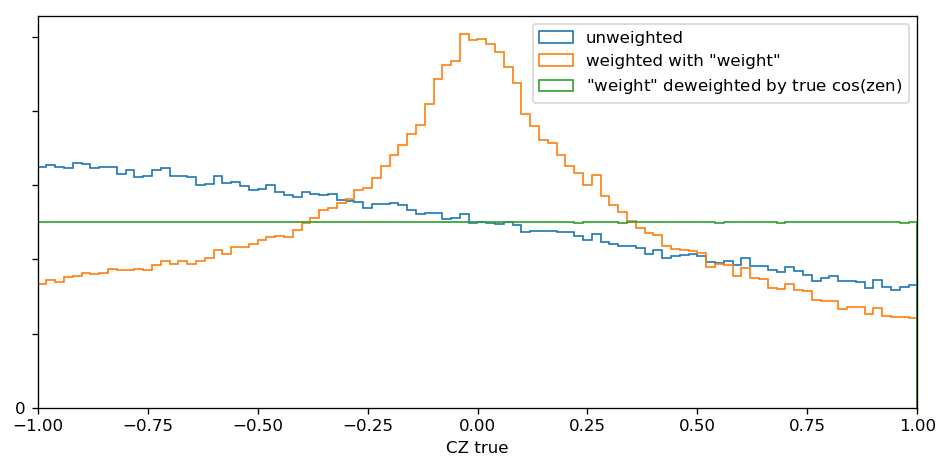

In [22]:
n_bins = 100

fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
unwtd_bvals, _, _ = ax.hist(truth['coszen'], bins=n_bins, density=True, histtype='step', label='unweighted')
wtd_bvals, _, _ = ax.hist(truth['coszen'], weights=truth['weight'], bins=n_bins, density=True, histtype='step', label='weighted with "weight"')

# -- Deweight by coszen -- #
czbins = np.linspace(-1, 1, 1000 + 1)
param, bins, wts = 'coszen', czbins, (truth['weight'])
bin_labels = np.digitize(truth[param], bins=bins)
vals, _ = np.histogram(truth[param], bins=bins, weights=wts)
new_wts = deepcopy(wts)
for bnum, val in enumerate(vals):
    new_wts[bin_labels == (bnum + 1)] /= val
    
dwtd_lbl = r'"weight" deweighted by true cos(${\rm zen}$)'

# -- Dewieght by energy -- #
#ebins = np.logspace(0, 3, 1000 + 1)
##ebins = np.linspace(1, 1000, n_bins + 1)
# param, bins, wts = 'energy', ebins, new_wts
# bin_labels = np.digitize(truth[param], bins=bins)
# vals, _ = np.histogram(truth[param], bins=bins, weights=wts)
# new_wts = deepcopy(wts)
# for bnum, val in enumerate(vals):
#     new_wts[bin_labels == (bnum + 1)] /= val

dewtd_bvals, bins, _ = ax.hist(truth['coszen'], bins=n_bins, weights=new_wts, density=True, histtype='step', label=dwtd_lbl)

ax.legend(loc='best')
ax.set_xlim(-1, 1)
ax.set_xlabel('CZ true')
ax.set_yticklabels([0])
fig.tight_layout()
basefpath = join(outdir, 'true_coszen_dist')
fig.savefig(basefpath + '.png', dpi=120)
fig.savefig(basefpath + '.pdf')
pass

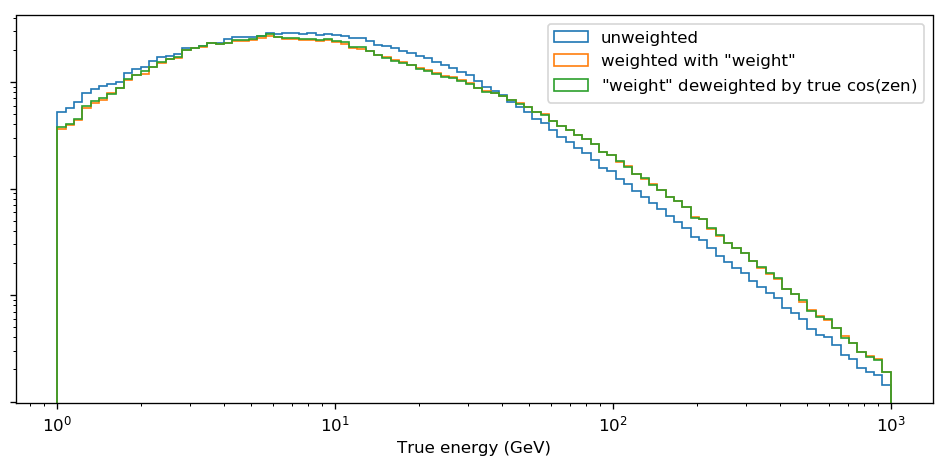

In [23]:
n_bins = 100
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
bins = np.logspace(0, 3, n_bins + 1)
_, bins, _ = ax.hist(truth['energy'], bins=bins, density=True, histtype='step', label='unweighted')
_, bins, _ = ax.hist(truth['energy'], weights=truth['weight'], bins=bins, density=True, histtype='step', label='weighted with "weight"')
_, bins, _ = ax.hist(truth['energy'], weights=new_wts, bins=bins, density=True, histtype='step', label=dwtd_lbl)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')
# ax.set_xlim(-1, 1)
ax.set_xlabel('True energy (GeV)')
ax.set_yticklabels([])
fig.tight_layout()
basefpath = join(outdir, 'true_energy_dist')
fig.savefig(basefpath + '.png', dpi=120)
fig.savefig(basefpath + '.pdf')
pass

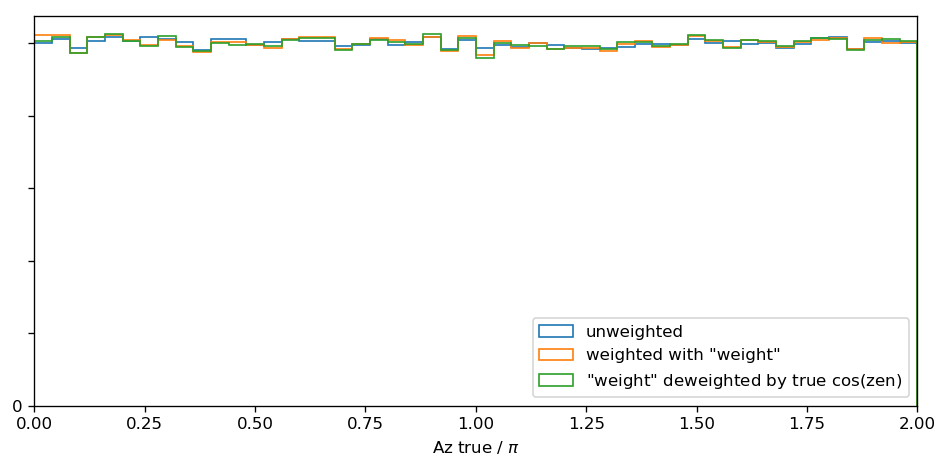

In [24]:
n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
_, bins, _ = ax.hist(truth['azimuth']/np.pi, bins=n_bins, density=True, histtype='step', label='unweighted')
_, bins, _ = ax.hist(truth['azimuth']/np.pi, weights=truth['weight'], bins=n_bins, density=True, histtype='step', label='weighted with "weight"')
_, bins, _ = ax.hist(truth['azimuth']/np.pi, weights=new_wts, bins=n_bins, density=True, histtype='step', label=dwtd_lbl)

#ax.set_xscale('log')
ax.legend(loc='lower right')
ax.set_xlim(0, 2)
ax.set_xlabel(r'Az true / $\pi$')
ax.set_yticklabels([0])
fig.tight_layout()
basefpath = join(outdir, 'true_azimuth_dist')
fig.savefig(basefpath + '.png', dpi=120)
fig.savefig(basefpath + '.pdf')
pass

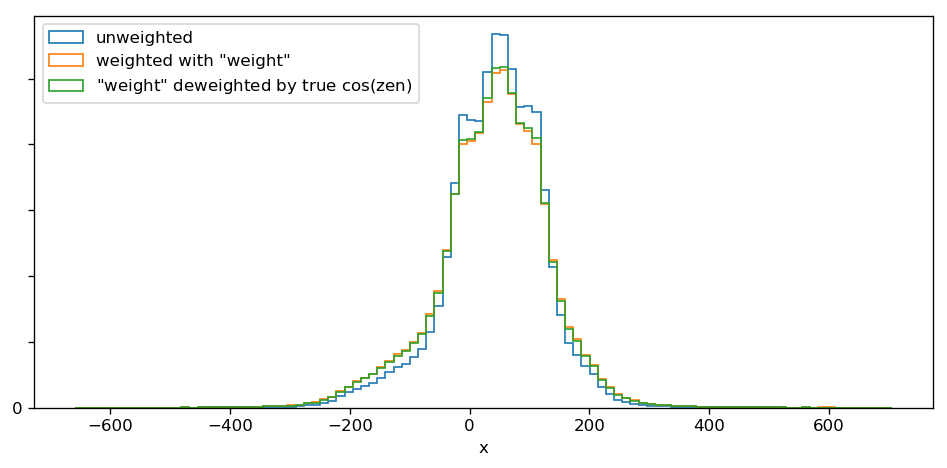

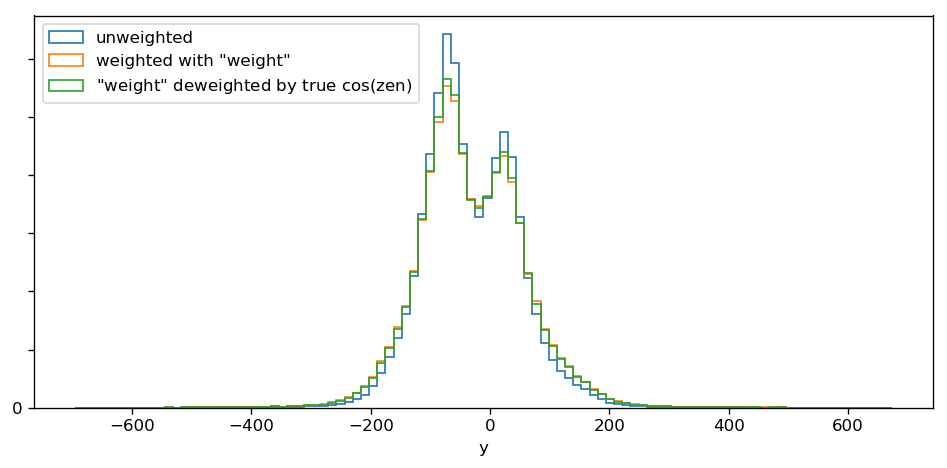

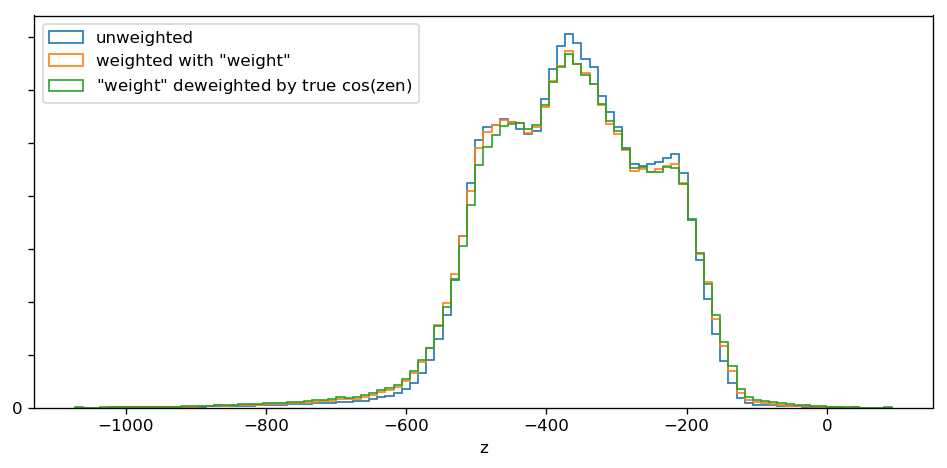

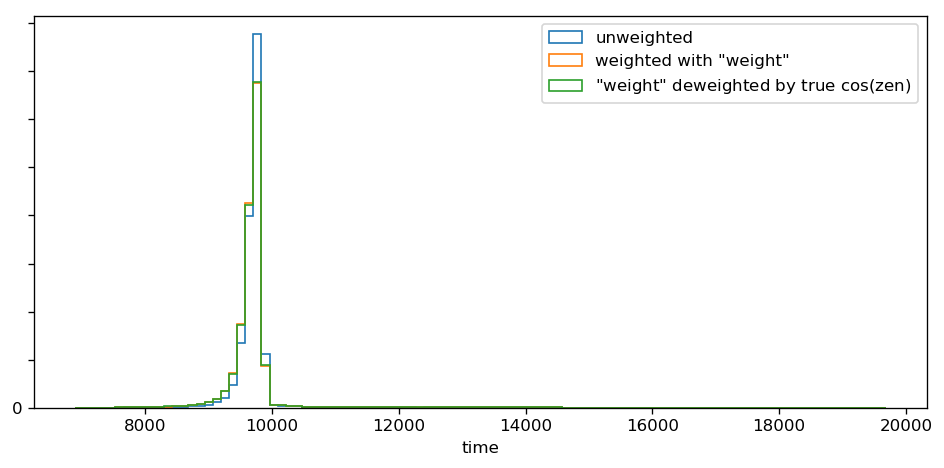

In [25]:
n_bins = 100
for param in ['x', 'y', 'z', 'time']:
    fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
    _, bins, _ = ax.hist(truth[param], bins=n_bins, density=True, histtype='step', label='unweighted')
    _, bins, _ = ax.hist(truth[param], weights=truth['weight'], bins=n_bins, density=True, histtype='step', label='weighted with "weight"')
    _, bins, _ = ax.hist(truth[param], weights=new_wts, bins=n_bins, density=True, histtype='step', label=dwtd_lbl)

    ax.legend(loc='upper right' if param == 'time' else 'upper left')
    ax.set_xlabel(param)
    ax.set_yticklabels([0])
    fig.tight_layout()
    basefpath = join(outdir, 'true_{}_dist'.format(param))
    fig.savefig(basefpath + '.png', dpi=120)
    fig.savefig(basefpath + '.pdf')

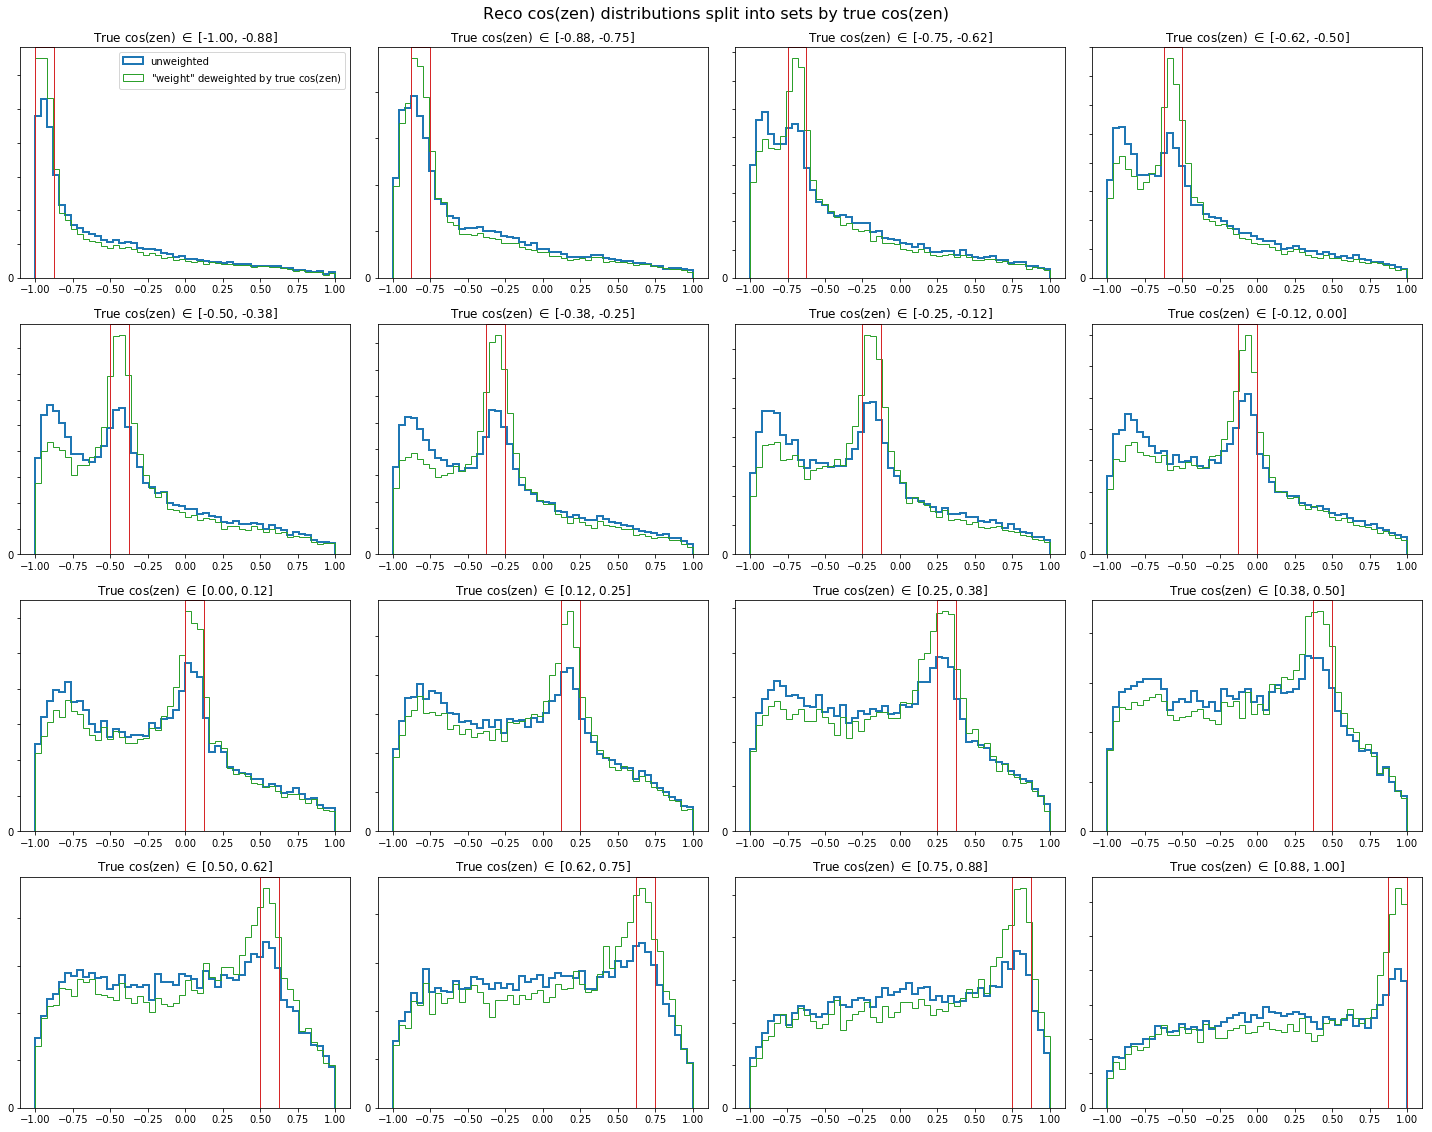

In [26]:
n_bins = 16
nb = 50
reco_name = 'L5_SPEFit11'
rcz = np.cos(recos[reco_name]['zenith'])

bin_edges = np.linspace(-1, 1, n_bins + 1)
mins = bin_edges[:-1]

fig, axes = plt.subplots(4, 4, figsize=(20, 16), dpi=72)
axiter = iter(axes.flat)
for i, ax in enumerate(axiter):
    range_min, range_max = bin_edges[i:i+2]
    mask = (truth['coszen'] >= range_min) & (truth['coszen'] <= range_max) & np.isfinite(rcz)
    rrcz = rcz[mask]
    wts = new_wts[mask]

    ax.hist(rrcz, weights=None, bins=nb, density=True, histtype='step', linewidth=2, label='unweighted')
    ax.hist(rrcz, weights=wts, bins=nb, density=True, histtype='step', color='C2', label=dwtd_lbl)
    if i == 0:
        ax.legend(loc='best')
    ax.set_yticklabels([0])

    ylim = ax.get_ylim()
    dy = ylim[1] - ylim[0]
    y0, y1 = ylim
    rect = patches.Rectangle((range_min, y0), range_max-range_min, y1-y0, linewidth=1, edgecolor='C3', facecolor='none')
    ax.add_patch(rect)
    ax.set_ylim(ylim)
    ax.set_title(r'True cos(zen) $\in$ [{:.2f}, {:.2f}]'.format(range_min, range_max))

fig.suptitle('Reco cos(zen) distributions split into sets by true cos(zen)', fontsize=16)
fig.tight_layout(rect=(0, 0, 1, 0.97))
basefpath = join(outdir, 'reco_coszen_dist_divby_true_coszen_{:d}'.format(n_bins))
fig.savefig(basefpath + '.png', dpi=120)
fig.savefig(basefpath + '.pdf')

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]



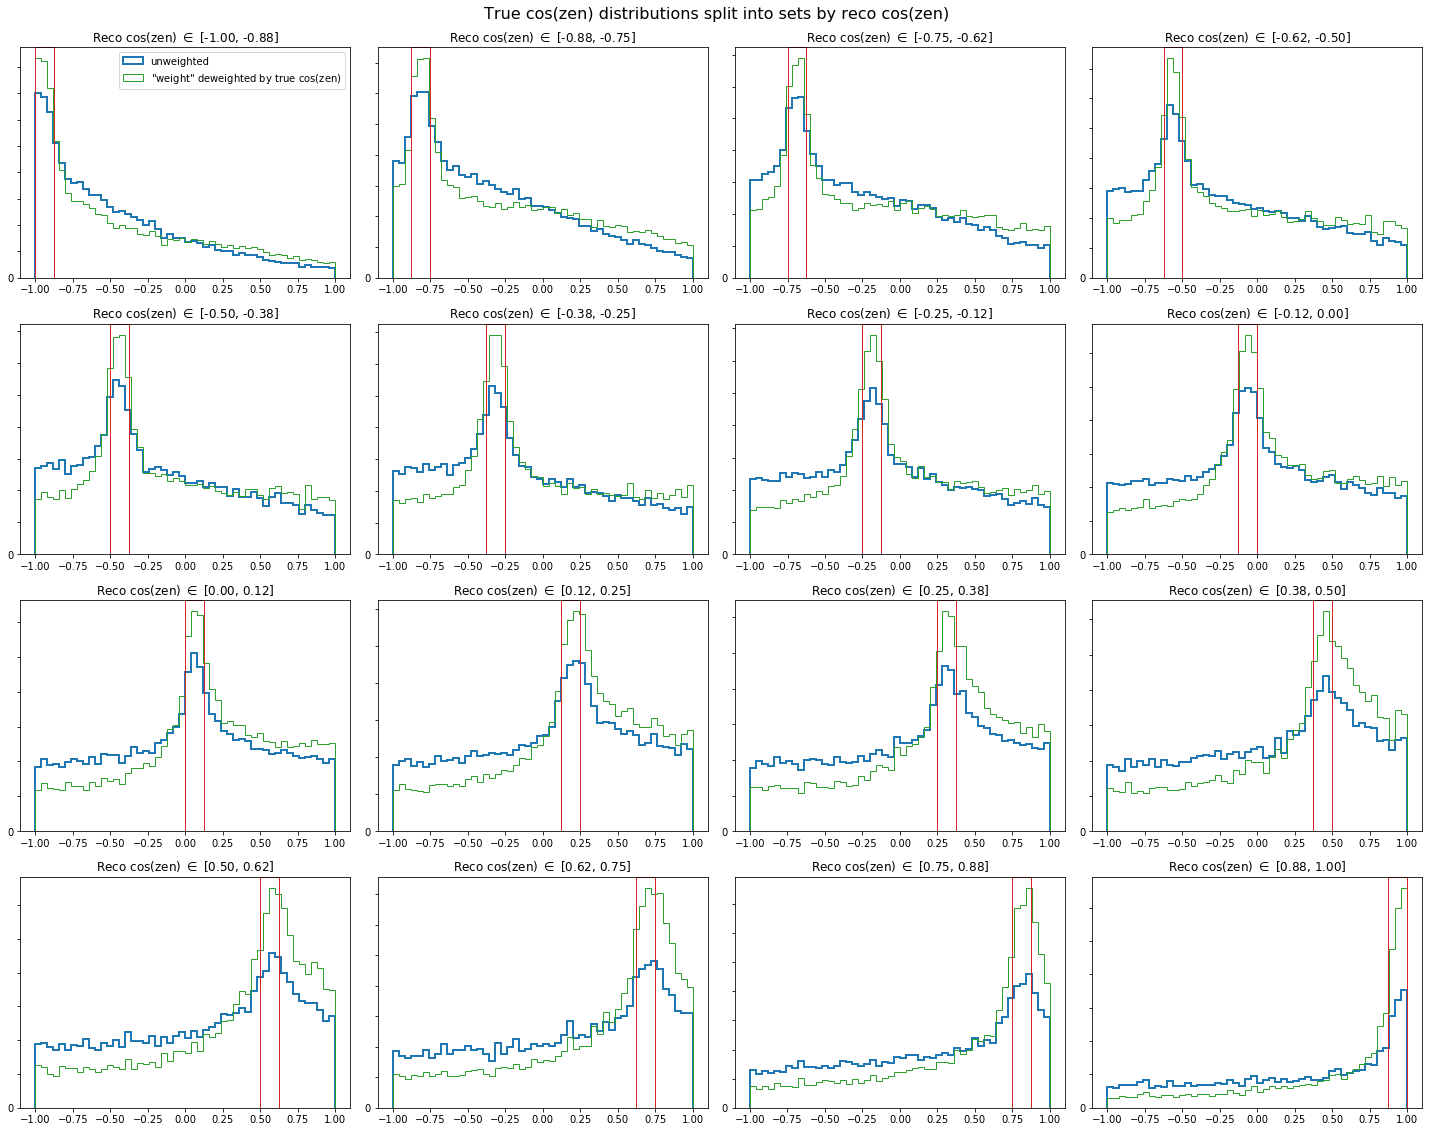

In [27]:
n_bins = 16
nb = 50
reco_name = 'L5_SPEFit11'
rcz = np.cos(recos[reco_name]['zenith'])

bin_edges = np.linspace(-1, 1, n_bins + 1)
mins = bin_edges[:-1]

fig, axes = plt.subplots(4, 4, figsize=(20, 16), dpi=72)
axiter = iter(axes.flat)
for i, ax in enumerate(axiter):
    range_min, range_max = bin_edges[i:i+2]
    mask = (rcz >= range_min) & (rcz <= range_max) & np.isfinite(rcz)
    ttcz = truth['coszen'][mask]
    wts = new_wts[mask]

    ax.hist(ttcz, weights=None, bins=nb, density=True, histtype='step', linewidth=2, label='unweighted')
    ax.hist(ttcz, weights=wts, bins=nb, density=True, color='C2', histtype='step', label=dwtd_lbl)
    if i == 0:
        ax.legend(loc='best')
    ax.set_yticklabels([0])

    ylim = ax.get_ylim()
    dy = ylim[1] - ylim[0]
    y0, y1 = ylim
    rect = patches.Rectangle((range_min, y0), range_max-range_min, y1-y0, linewidth=1, edgecolor='C3', facecolor='none')
    ax.add_patch(rect)
    ax.set_ylim(ylim)
    ax.set_title(r'Reco cos(zen) $\in$ [{:.2f}, {:.2f}]'.format(range_min, range_max))

fig.suptitle('True cos(zen) distributions split into sets by reco cos(zen)', fontsize=16)
fig.tight_layout(rect=(0, 0, 1, 0.97))
basefpath = join(outdir, 'true_coszen_dist_divby_reco_coszen_{:d}'.format(n_bins))
fig.savefig(basefpath + '.png', dpi=120)
fig.savefig(basefpath + '.pdf')

## Validate coszen tail weighting code

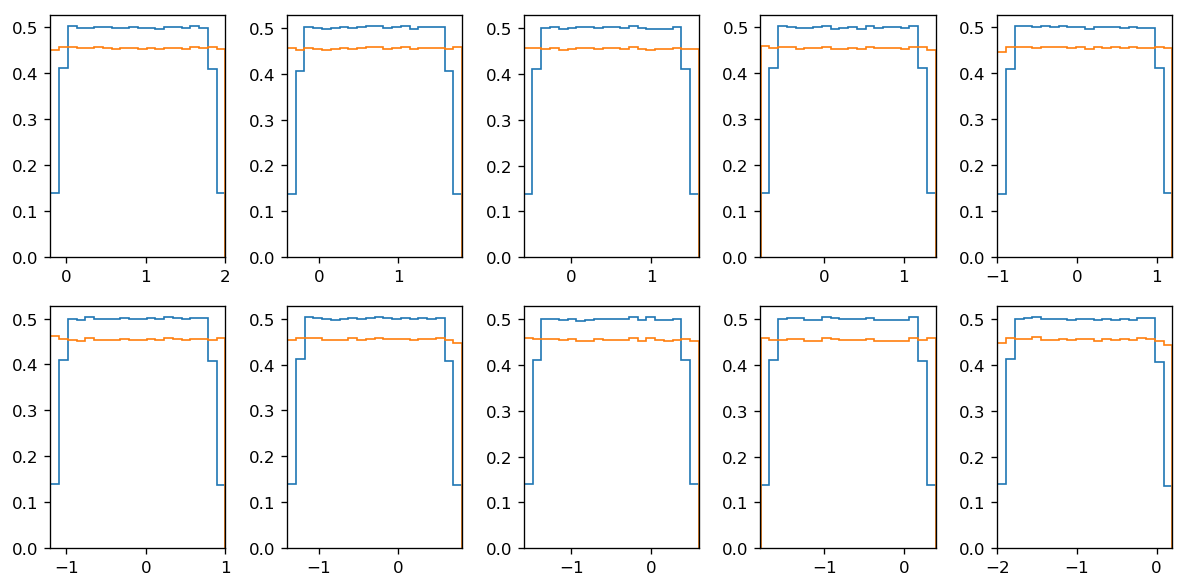

In [28]:
size = int(1e7)
nb = 10
pnb = 20
rand = np.random.RandomState(0)
t = rand.uniform(-1, 1, size=size)
r = rand.uniform(-1, 1, size=size)
e = r - t

be = np.linspace(-1, 1, nb + 1)

fig, axes = plt.subplots(2, 5, figsize=(10, 5), dpi=120)
axit = iter(axes.flat)
for i, ax in enumerate(axit):
    mask = (t >= be[i]) & (t <= be[i+1])
    w, dlims = weight_diff_tails(
        diff=e[mask],
        weights=np.array([]),
        inbin_lower=be[i],
        inbin_upper=be[i+1],
        range_lower=-1,
        range_upper=+1,
        max_weight=100.,
    )
    ax.hist(e[mask], bins=pnb, histtype='step', density=True)
    ax.hist(e[mask], weights=w, bins=pnb, histtype='step', density=True)
    ax.set_xlim(dlims)
    #break
fig.tight_layout()

# Characterize cos(zenith) for chosen recos

## L5_SPEFit11 cos(zen)

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_coszen_neg_error_splitby_reco_coszen_16.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_coszen_neg_error_splitby_reco_coszen_16.pkl"
CPU times: user 22.9 s, sys: 8.03 s, total: 30.9 s
Wall time: 30.9 s


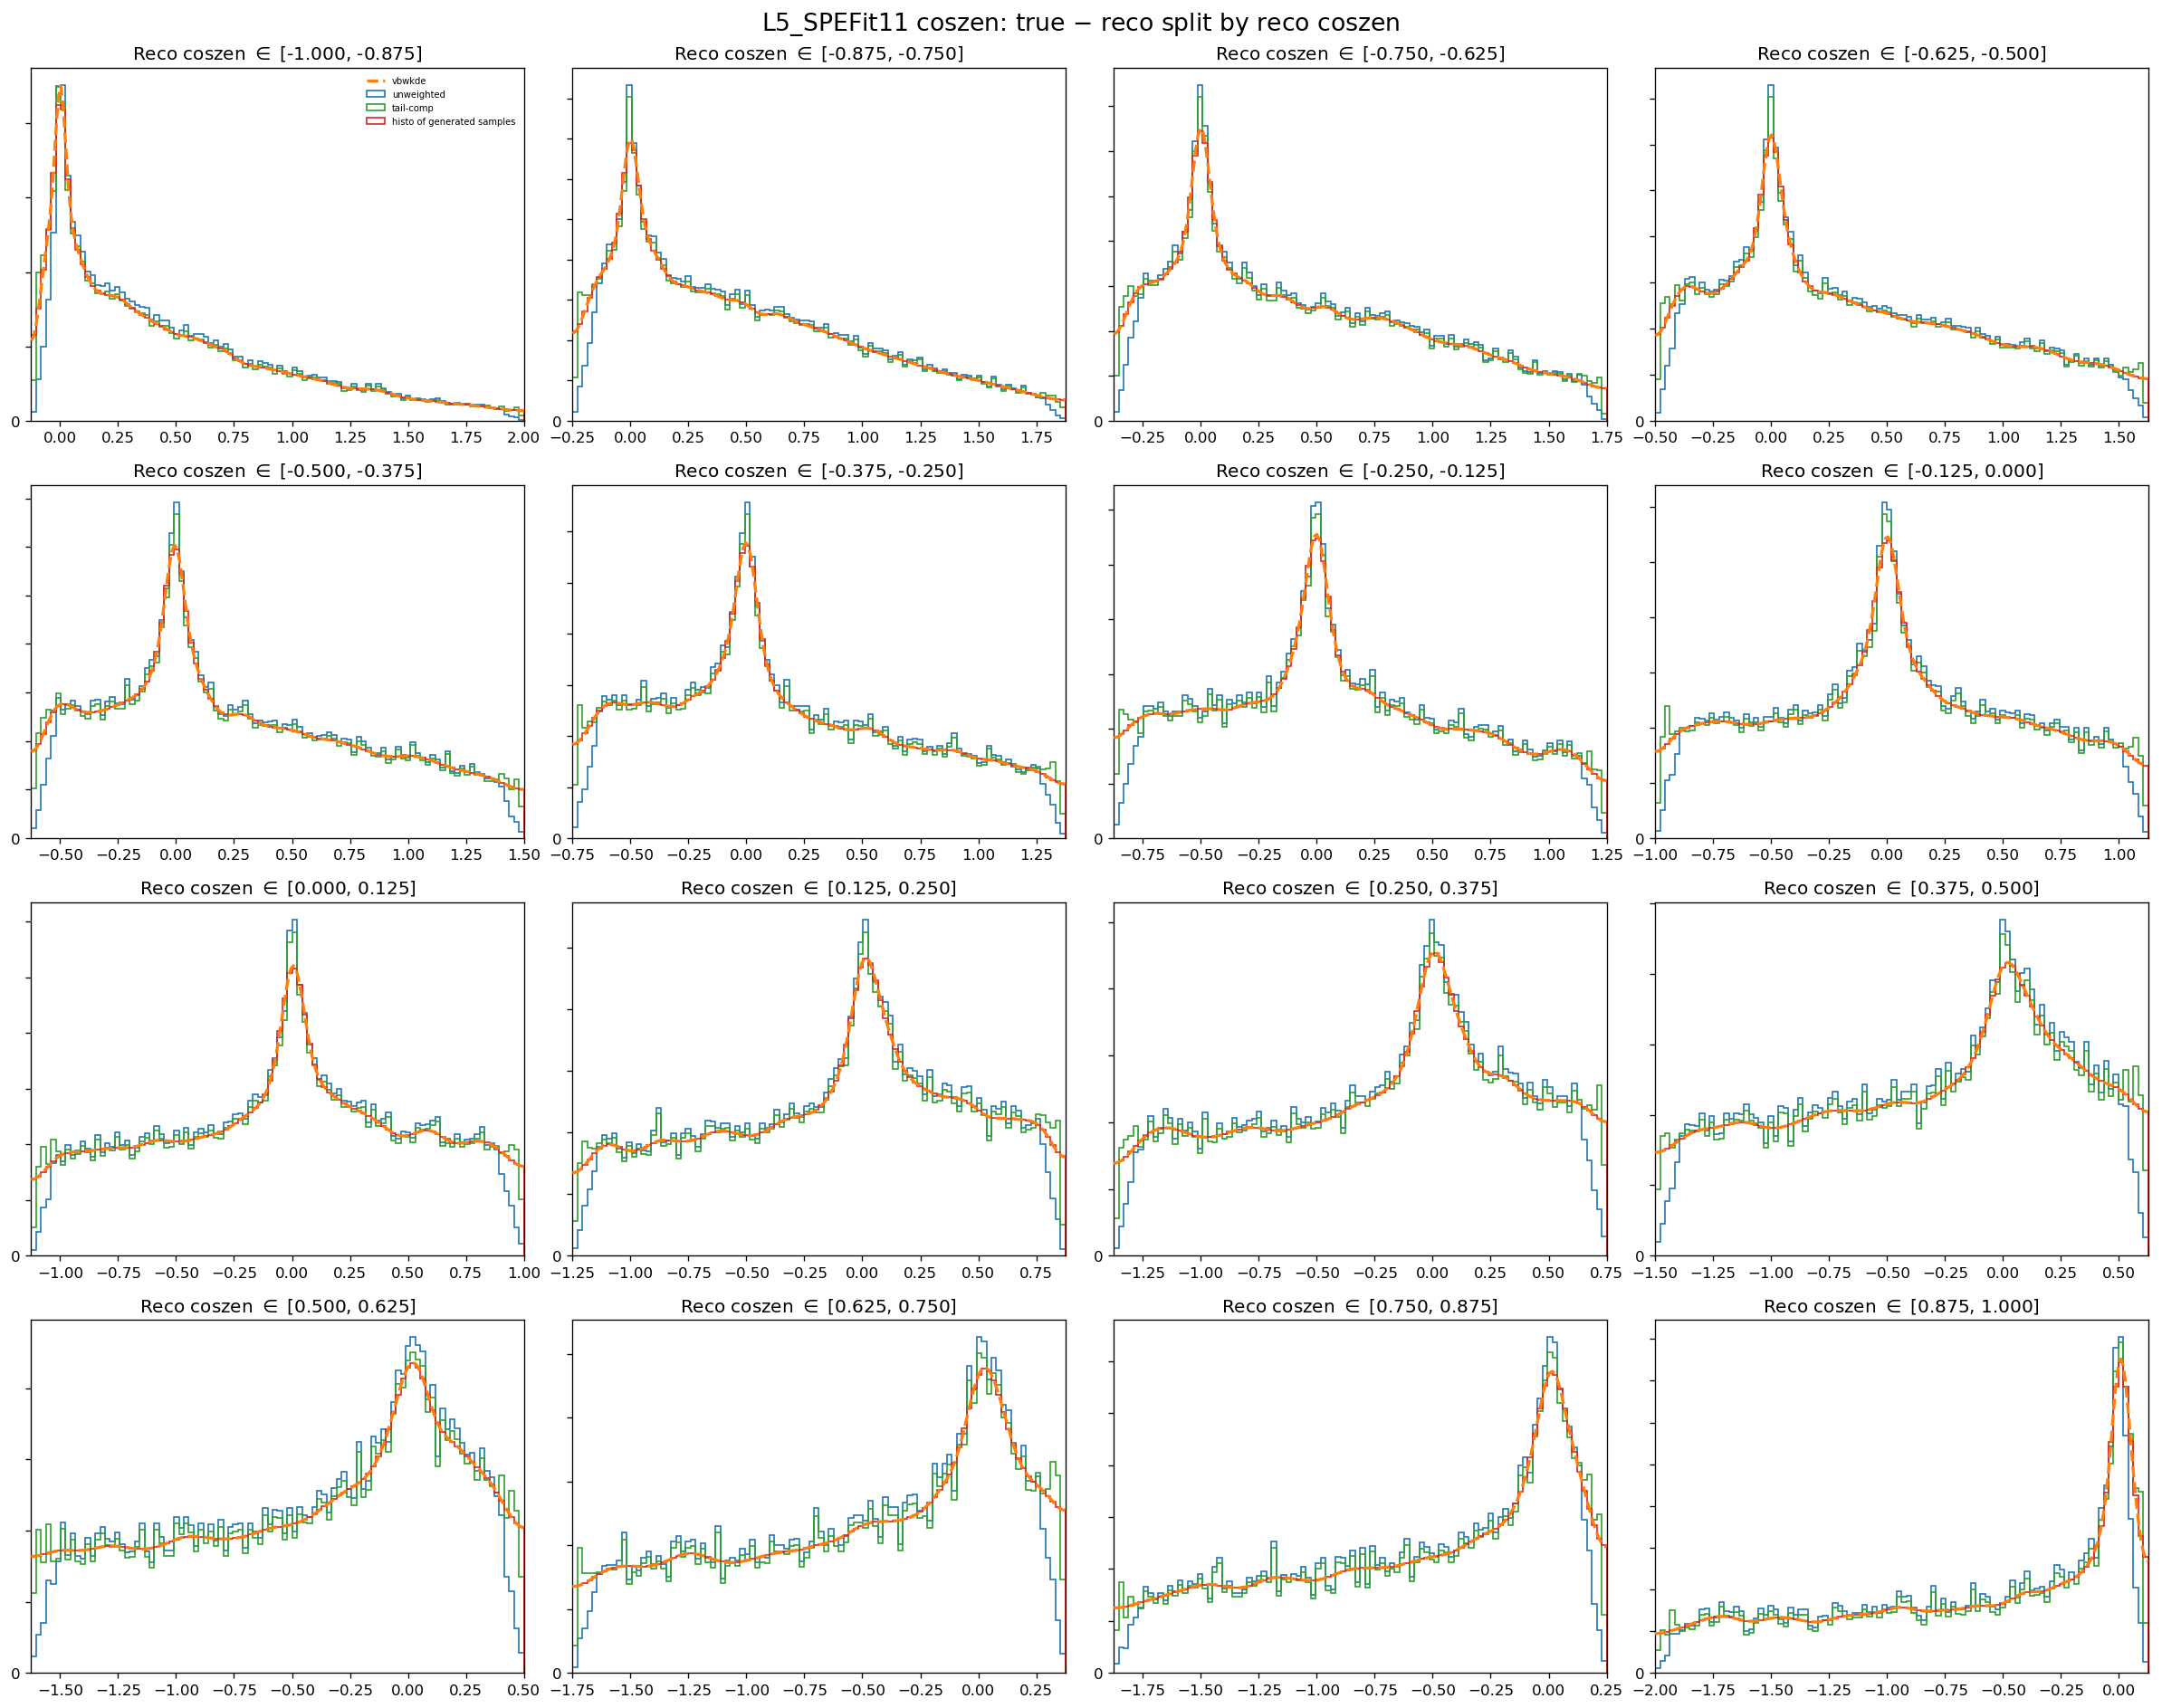

In [37]:
%%time

spe_coszen_neg_err_dists, axes = prior_from_reco(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='L5_SPEFit11',
    param='coszen',
    split_by_reco_param='coszen',
    num_split_bins=16,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=True,
    weight_tails_max_weight=5,
    mirror_about_finite_edges=True,  # since coszen does not go to ~0 or does so abruptly at edges
    num_density_samples=200,
    n_dct=2**7,
    n_addl_iter=2,
    n_plot_bins=100,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

## LineFit_DC cos(zen)

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_coszen_neg_error_splitby_reco_coszen_16.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_coszen_neg_error_splitby_reco_coszen_16.pkl"
CPU times: user 24.1 s, sys: 8.34 s, total: 32.5 s
Wall time: 32.5 s


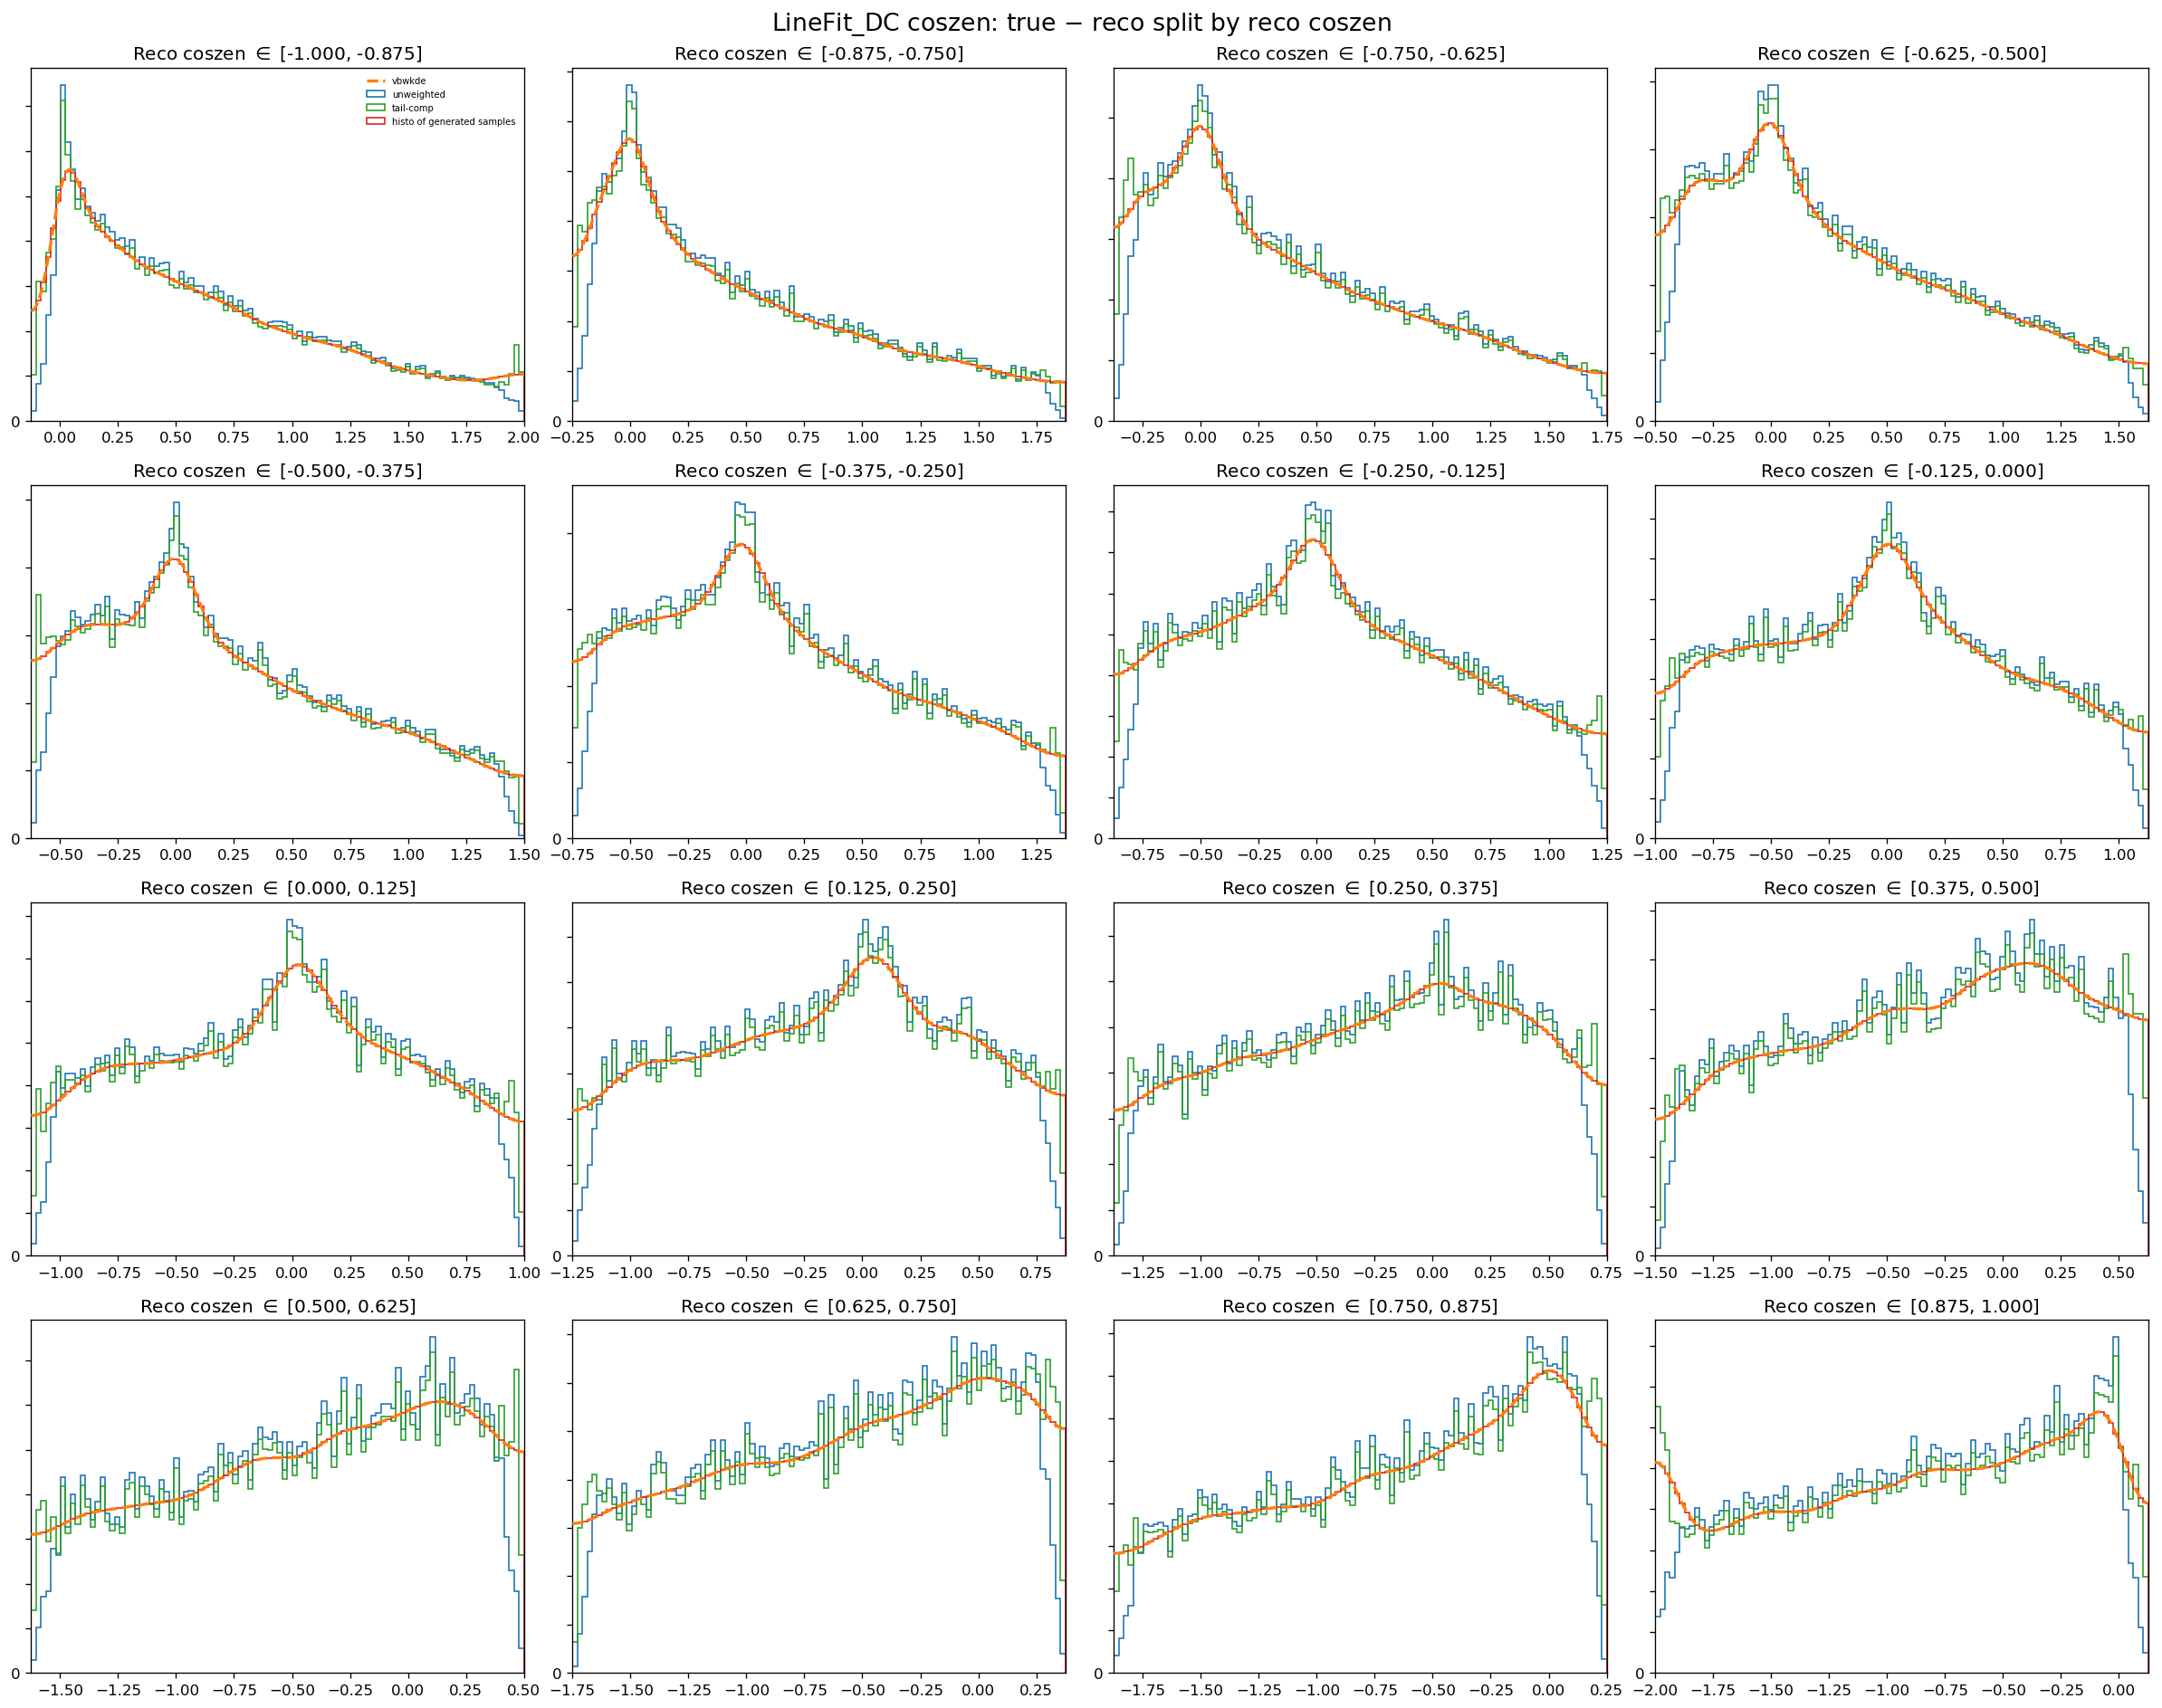

In [38]:
%%time

linefit_coszen_neg_err_dists, axes = prior_from_reco(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='LineFit_DC',
    param='coszen',
    split_by_reco_param='coszen',
    num_split_bins=16,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=True,
    weight_tails_max_weight=5,
    mirror_about_finite_edges=True,  # since coszen does not go to ~0 or does so abruptly at edges
    num_density_samples=200,
    n_dct=2**5,
    n_addl_iter=2,
    n_plot_bins=100,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

# Characterize zenith for chosen recos

## L5_SPEFit11 zenith

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_zenith_neg_error_splitby_reco_coszen_16.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_zenith_neg_error_splitby_reco_coszen_16.pkl"
CPU times: user 5.98 s, sys: 1.12 s, total: 7.1 s
Wall time: 7.09 s


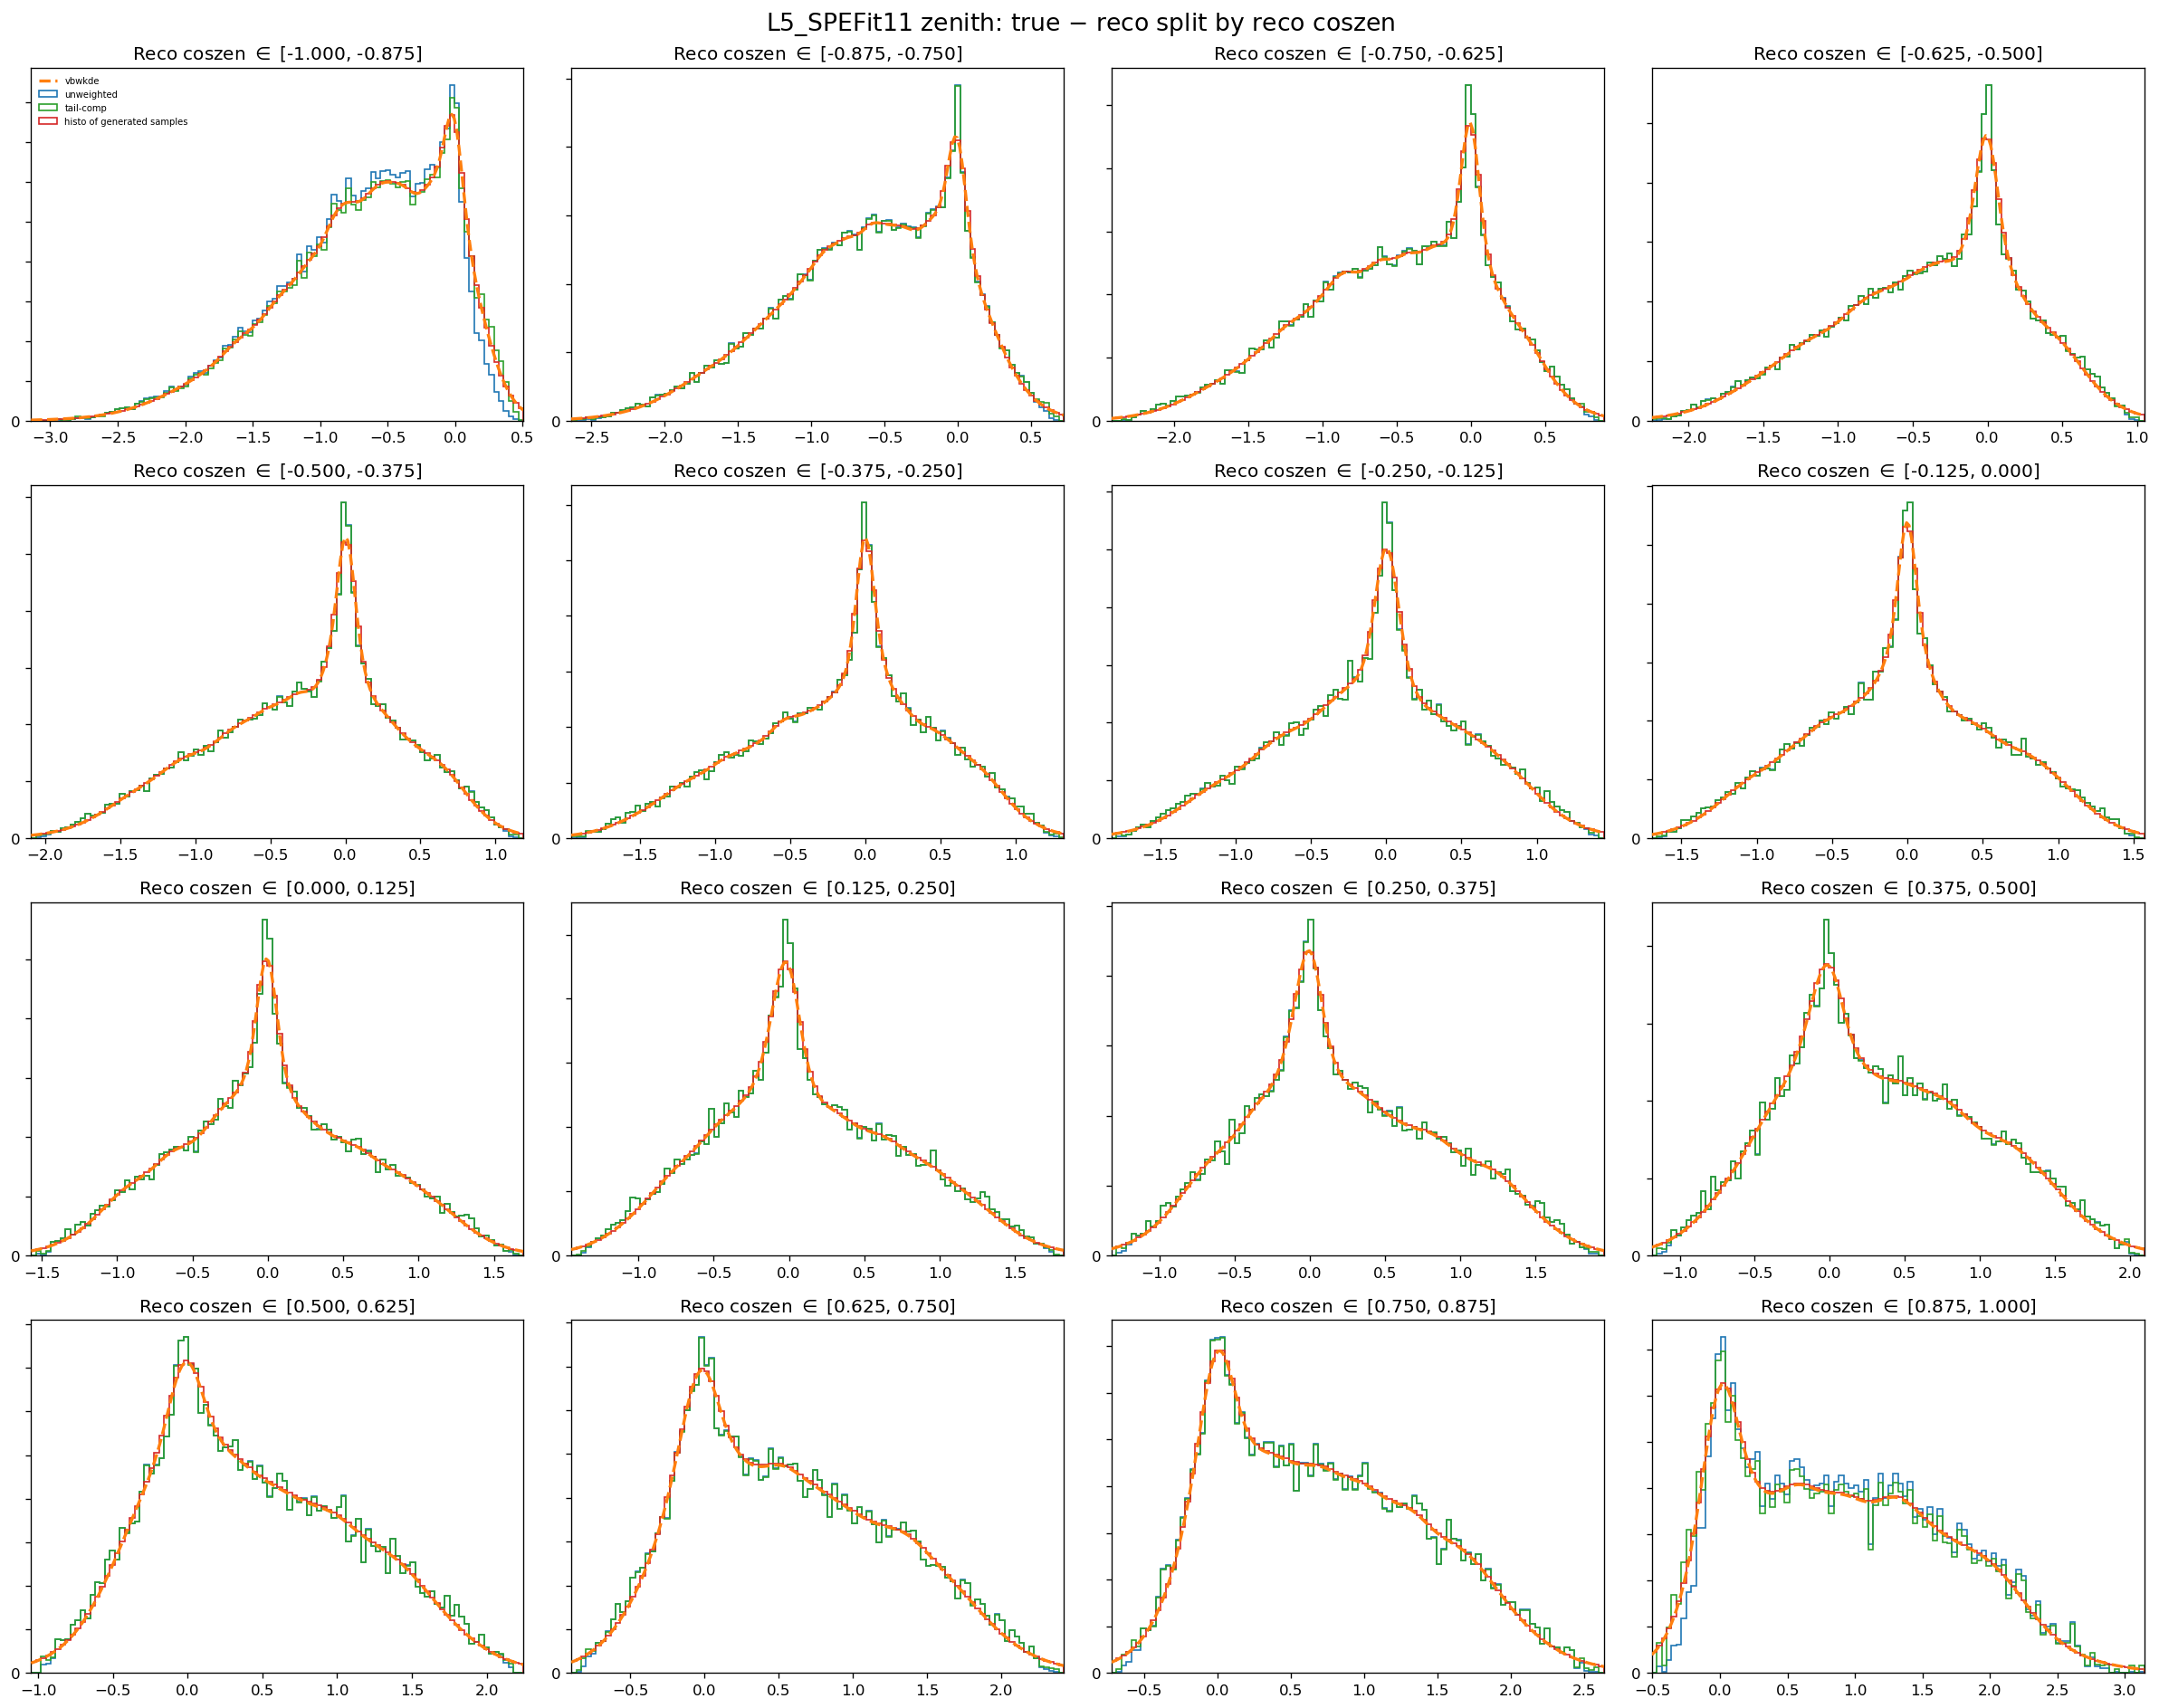

In [39]:
%%time

spe_zenith_neg_err_dists, axes = prior_from_reco(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='L5_SPEFit11',
    param='zenith',
    split_by_reco_param='coszen',
    num_split_bins=16,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=True,
    weight_tails_max_weight=5,
    mirror_about_finite_edges=False,  # since zenith goes to ~0 gradually at edges; still some overshoot, though...
    num_density_samples=200,
    n_dct=2**5,
    n_addl_iter=2,
    n_plot_bins=100,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

## LineFit_DC zenith

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_zenith_neg_error_splitby_reco_coszen_16.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_zenith_neg_error_splitby_reco_coszen_16.pkl"
CPU times: user 6.32 s, sys: 1.13 s, total: 7.45 s
Wall time: 7.44 s


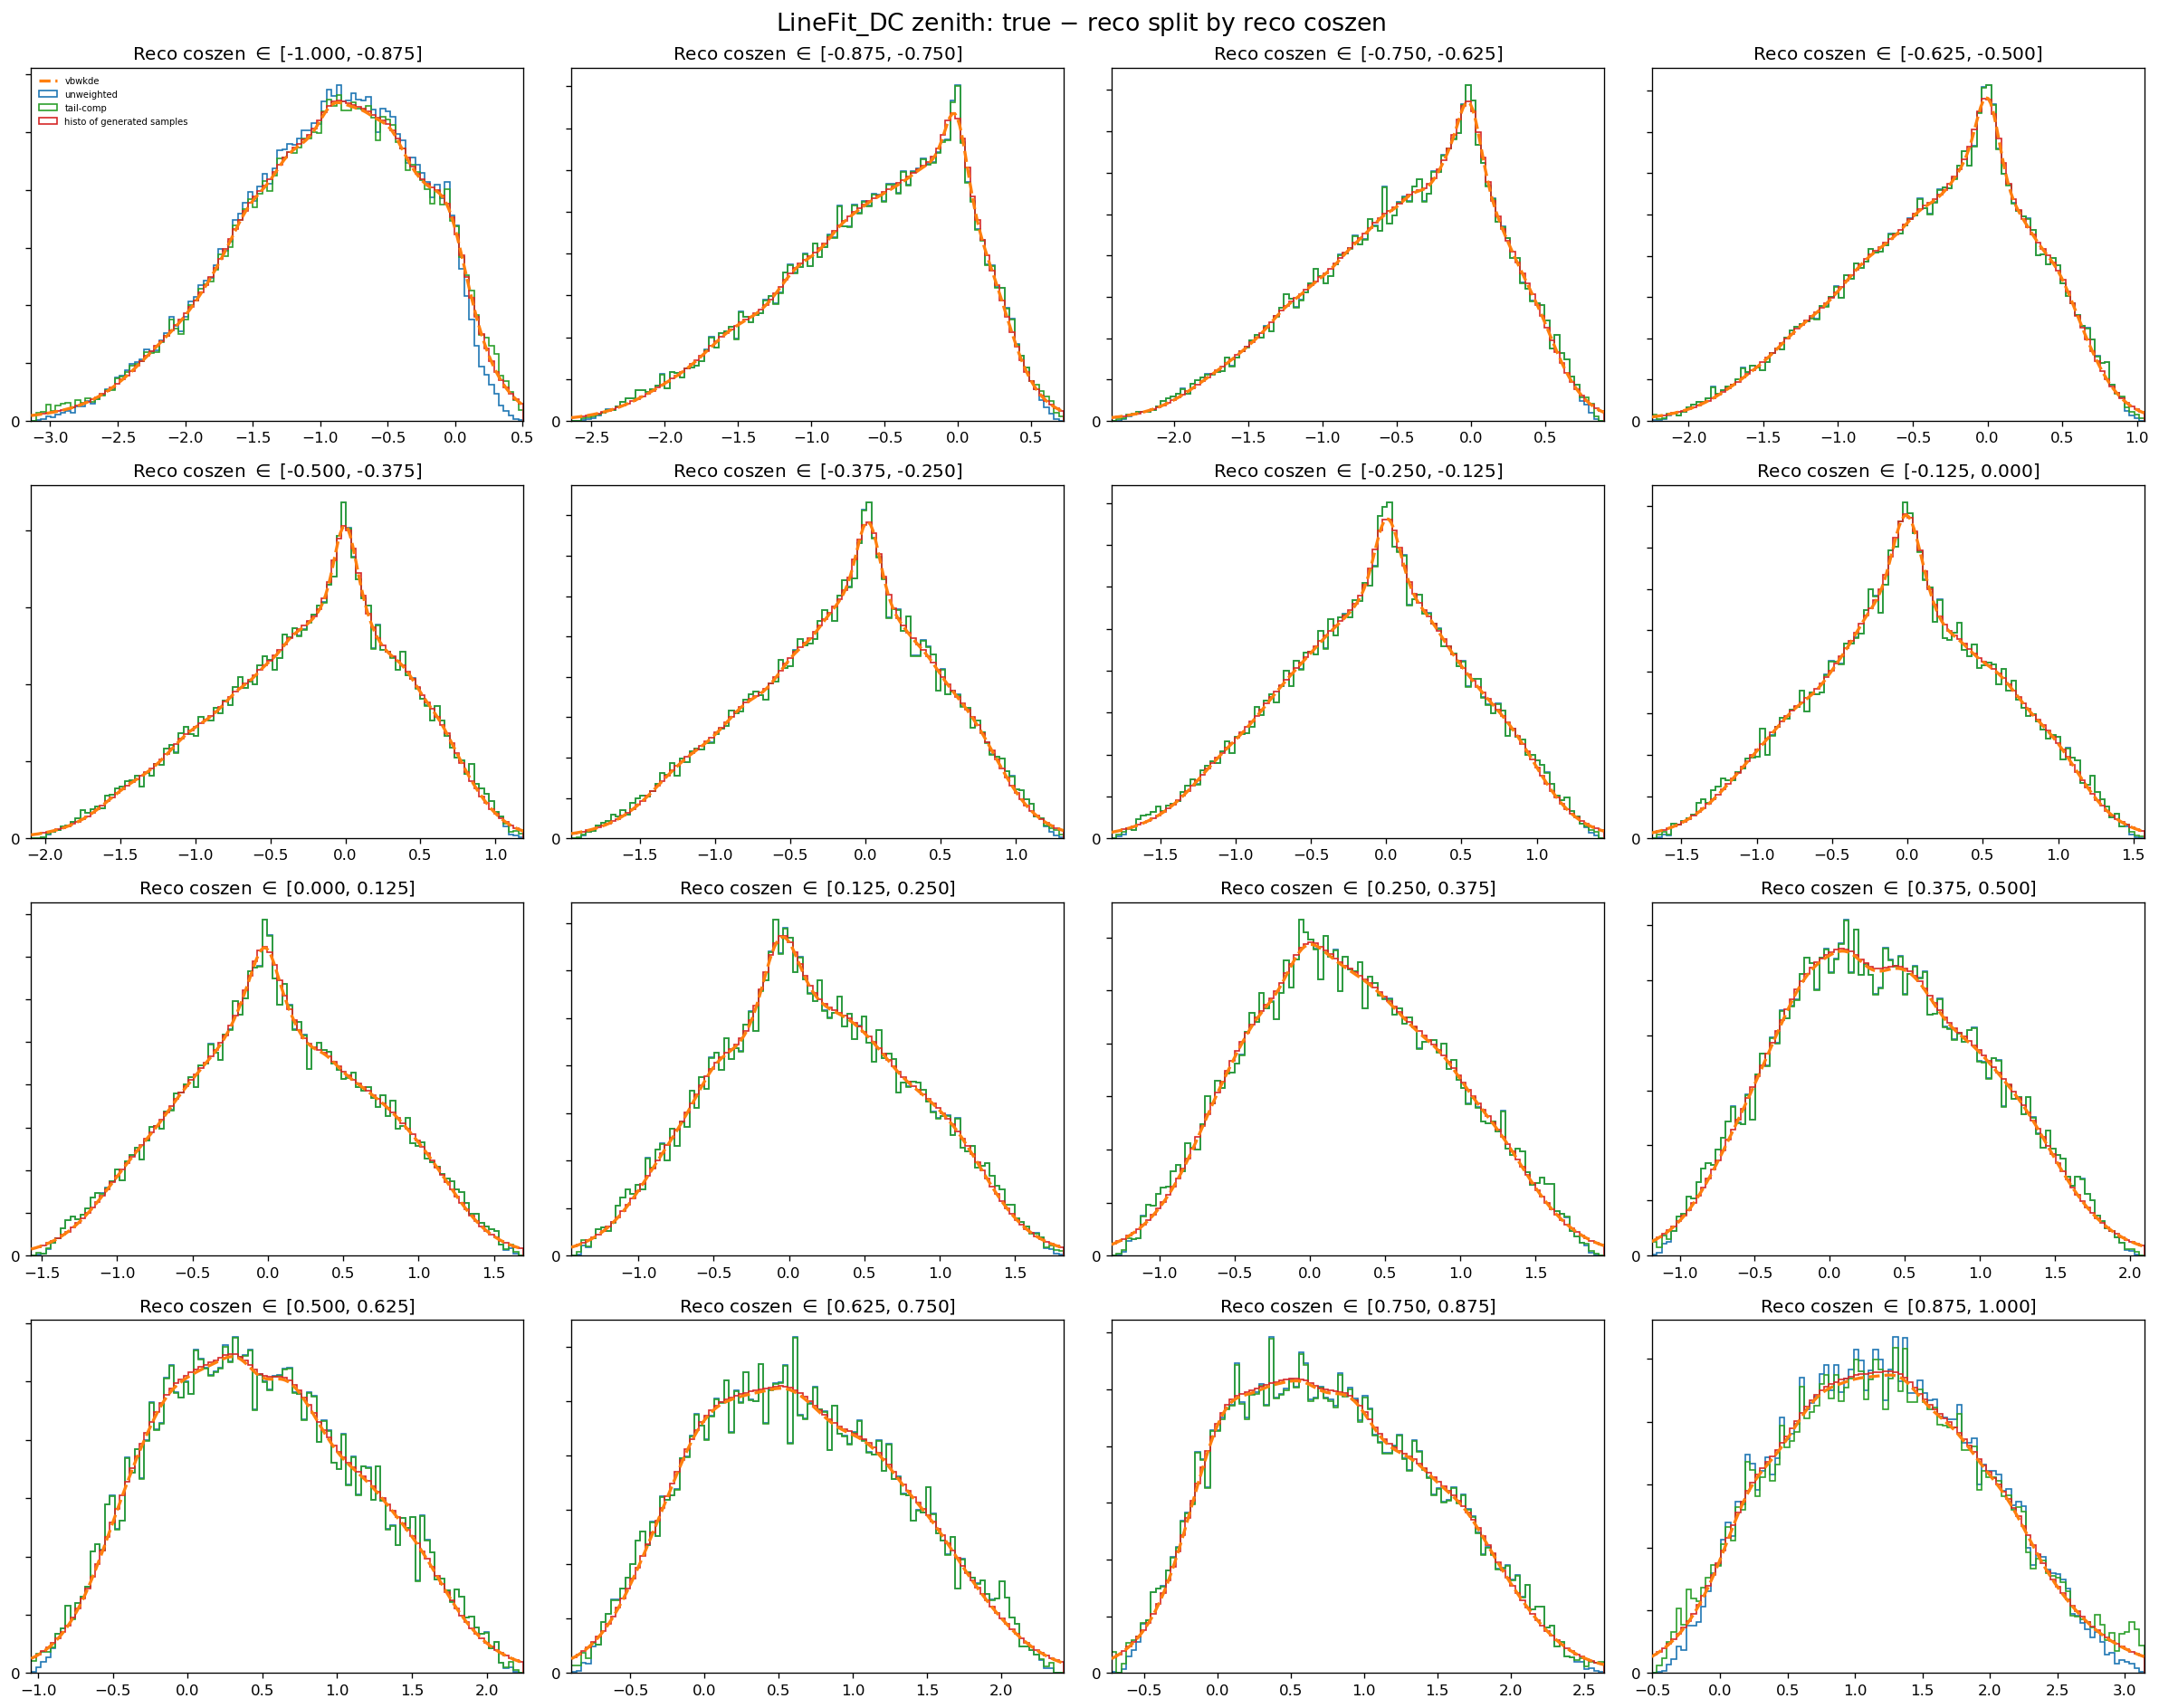

In [40]:
%%time

linefit_zenith_neg_err_dists, axes = prior_from_reco(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='LineFit_DC',
    param='zenith',
    split_by_reco_param='coszen',
    num_split_bins=16,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=True,
    weight_tails_max_weight=np.inf,
    mirror_about_finite_edges=False,  # fits better since zenith distributions go to ~0 smoothly, gradually at edges
    num_density_samples=200,
    n_dct=2**6,
    n_addl_iter=2,
    n_plot_bins=100,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

# Characterize azimuth for chosen recos

## L5_SPEFit11 azimuth

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_azimuth_neg_error_splitby_reco_coszen_10.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_azimuth_neg_error_splitby_reco_coszen_10.pkl"
CPU times: user 31.8 s, sys: 11.6 s, total: 43.4 s
Wall time: 43.4 s


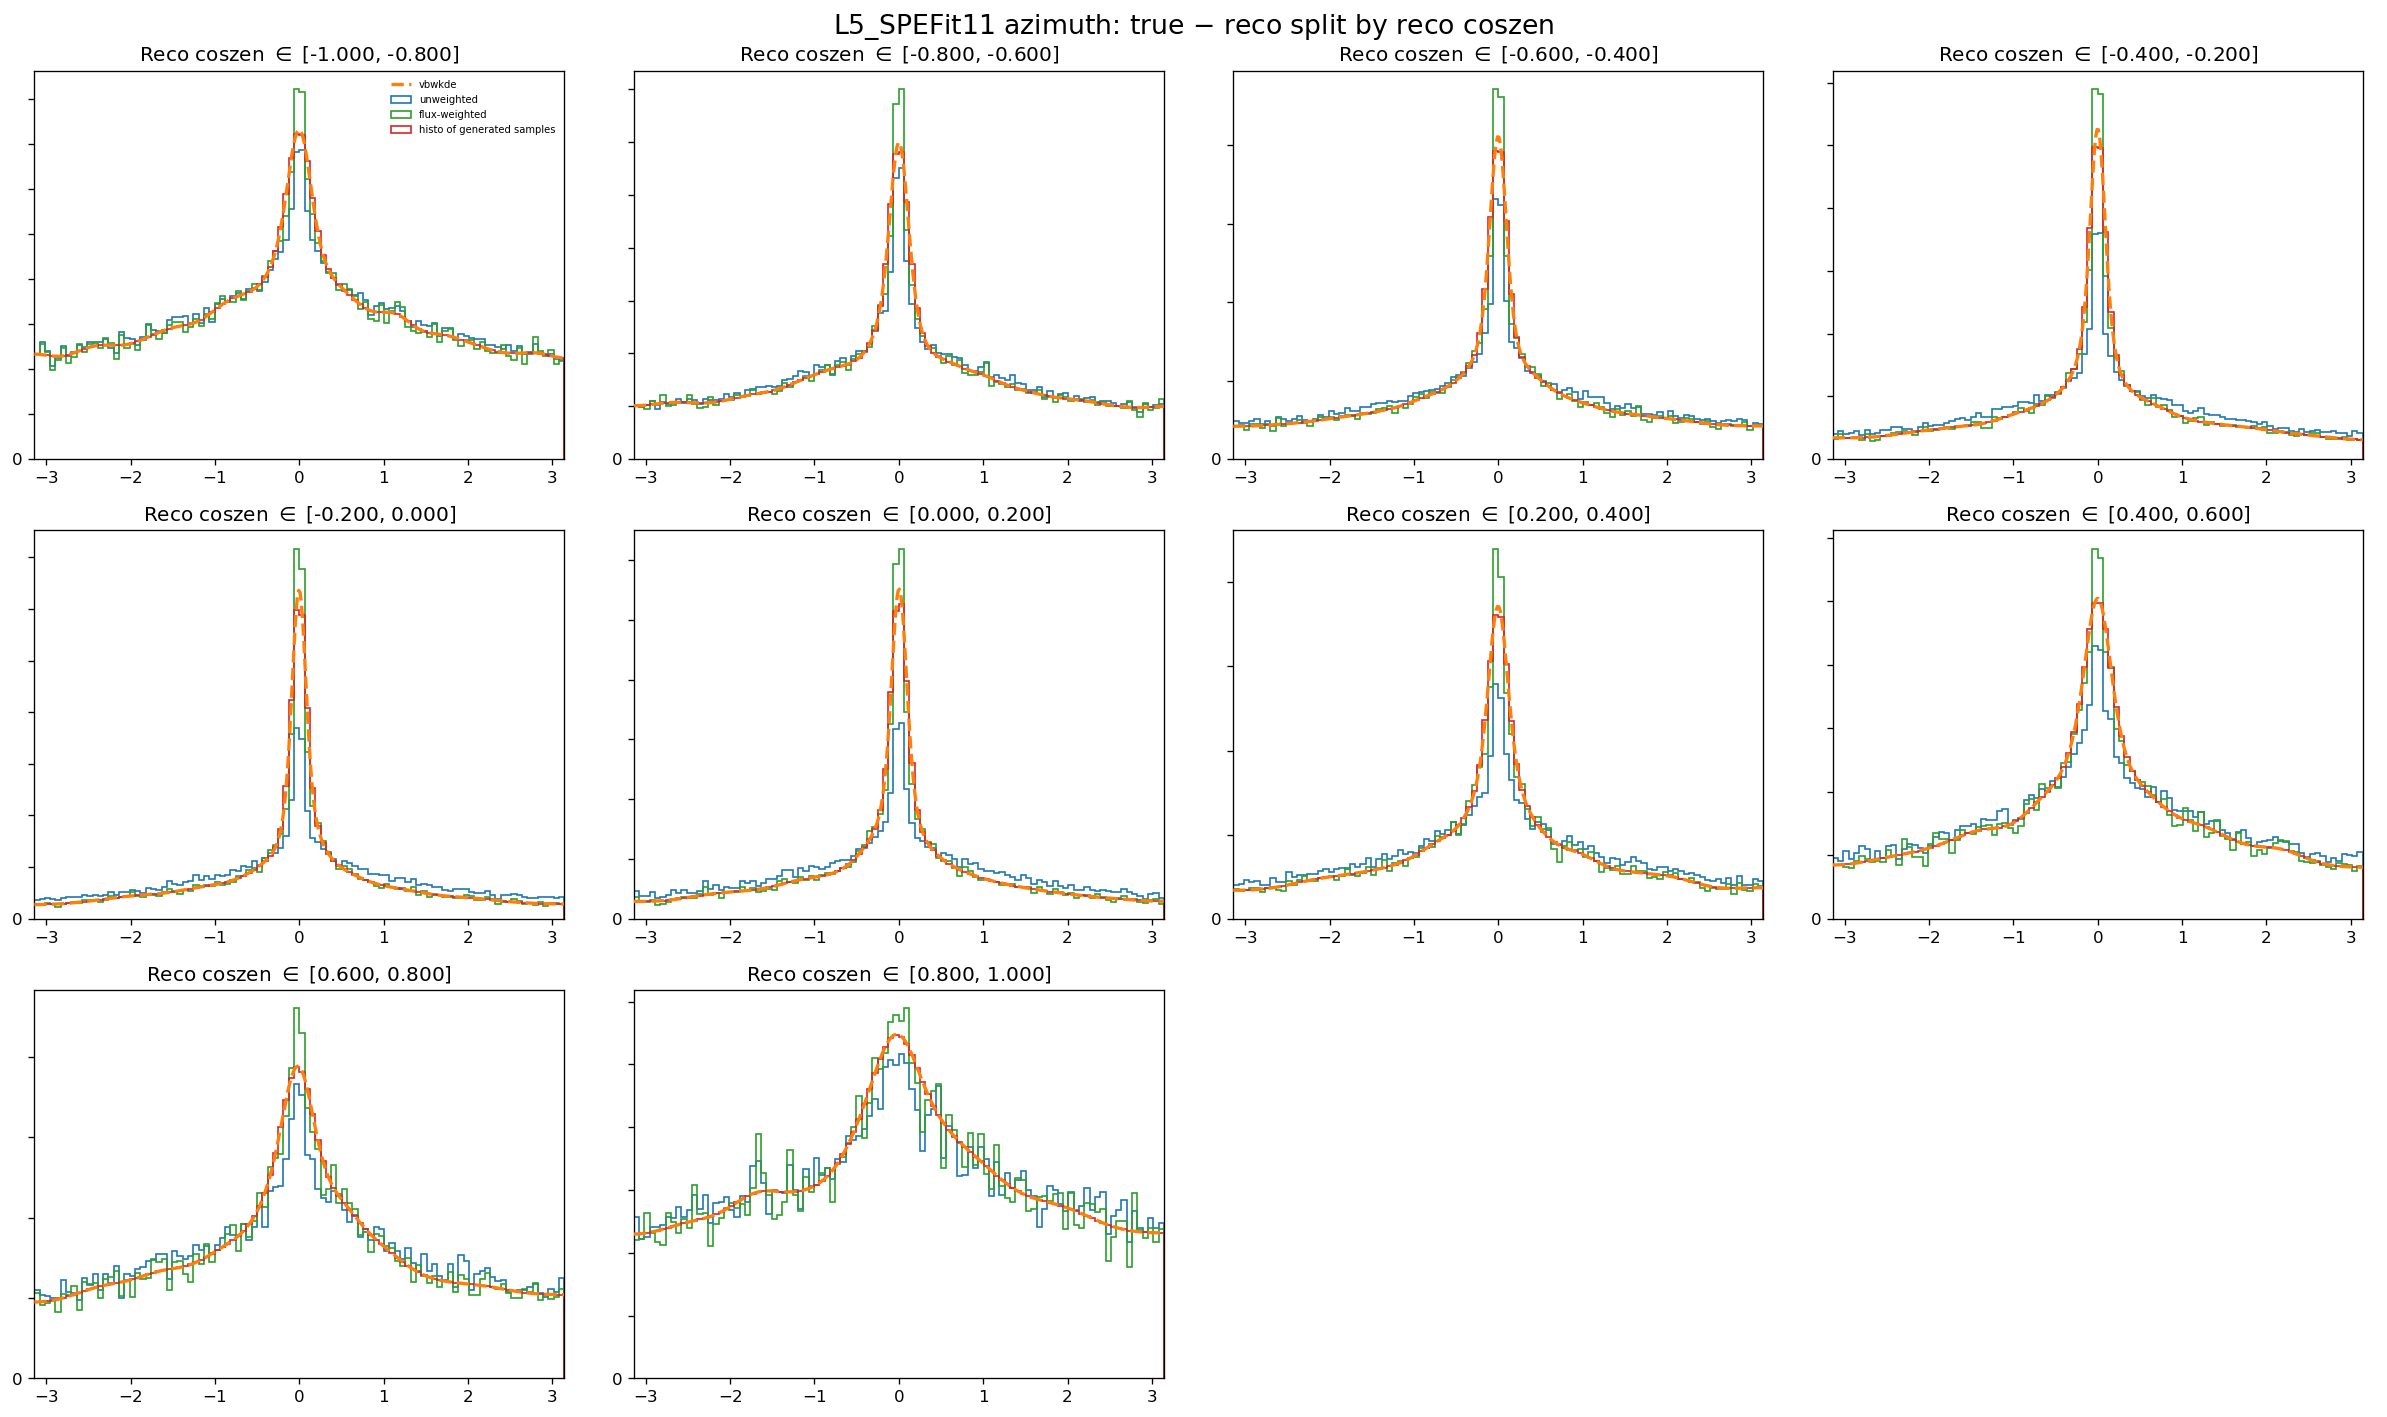

In [41]:
%%time

spe_azimuth_neg_err_dists, axes = prior_from_reco(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='L5_SPEFit11',
    param='azimuth',
    split_by_reco_param='coszen',
    num_split_bins=10,
    use_flux_weights=True,
    deweight_by_true_params=None,
    weight_tails=False,
    weight_tails_max_weight=None,
    mirror_about_finite_edges=True,
    num_density_samples=400,
    n_dct=2**6,
    n_addl_iter=2,
    n_plot_bins=100,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

## LineFit_DC azimuth

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_azimuth_neg_error_splitby_reco_coszen_10.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_azimuth_neg_error_splitby_reco_coszen_10.pkl"
CPU times: user 35.6 s, sys: 13.4 s, total: 49 s
Wall time: 49 s


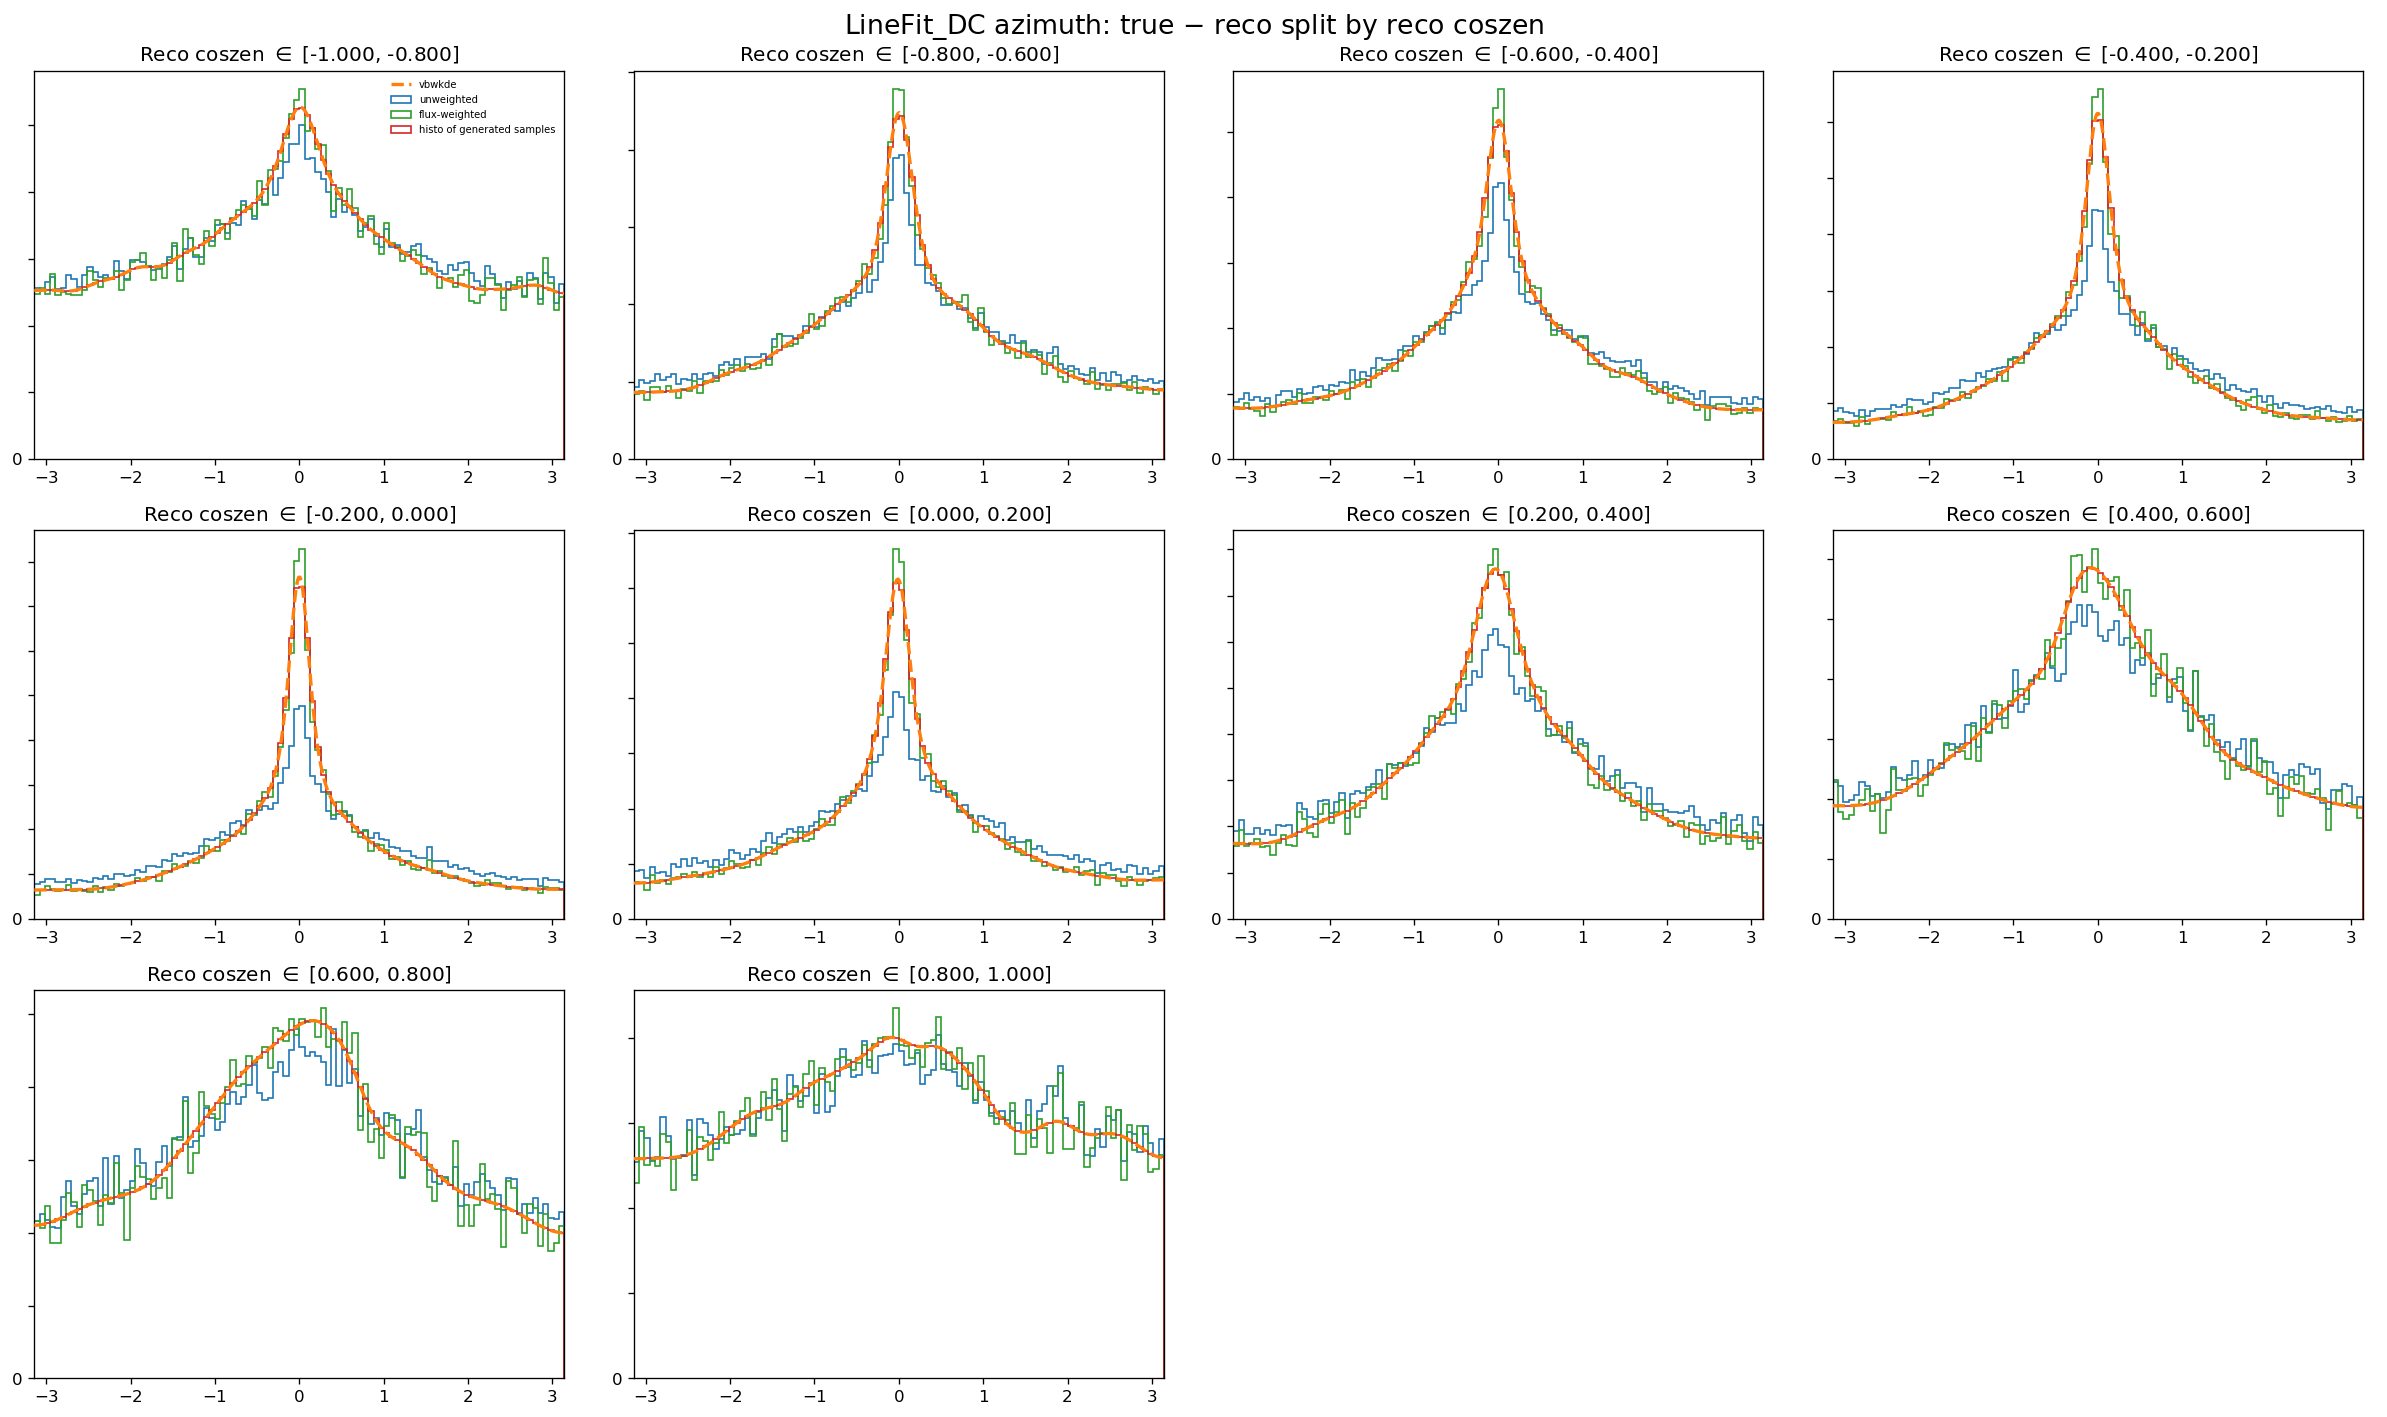

In [42]:
%%time

linefit_azimuth_neg_err_dists, axes = prior_from_reco(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='LineFit_DC',
    param='azimuth',
    split_by_reco_param='coszen',
    num_split_bins=10,
    use_flux_weights=True,
    deweight_by_true_params=None,
    weight_tails=False,
    weight_tails_max_weight=None,
    mirror_about_finite_edges=True,
    num_density_samples=400,
    n_dct=2**6, # originally: 2**4
    n_addl_iter=2,  # intentionally set to 0 to keep overly-smooth fits
    n_plot_bins=100,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

# Characterize x, y, z, and time for chosen recos

## L5_SPEFit11 x, y, z, and time

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_x_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_x_neg_error.pkl"


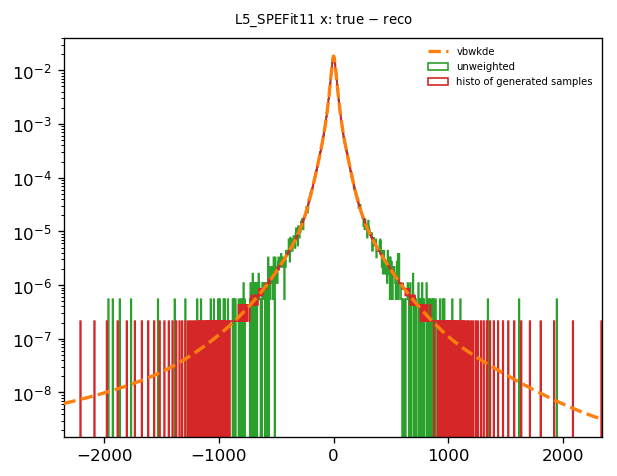

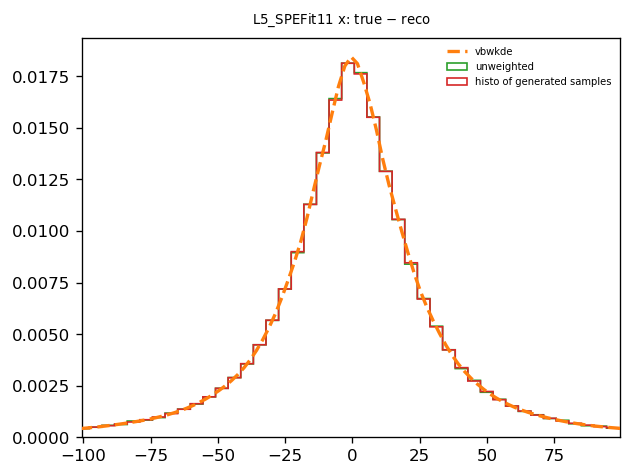

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_y_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_y_neg_error.pkl"


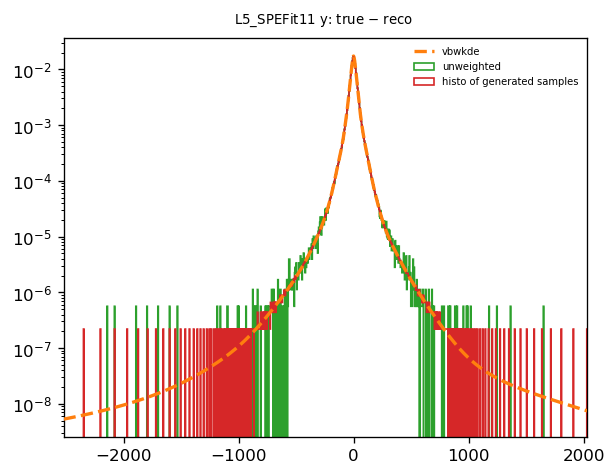

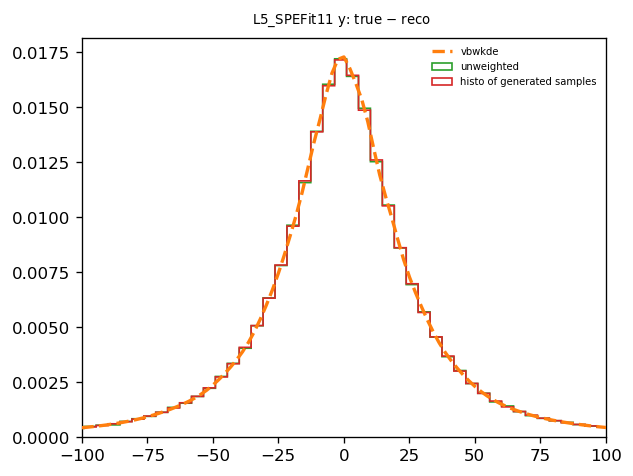

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_z_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_z_neg_error.pkl"


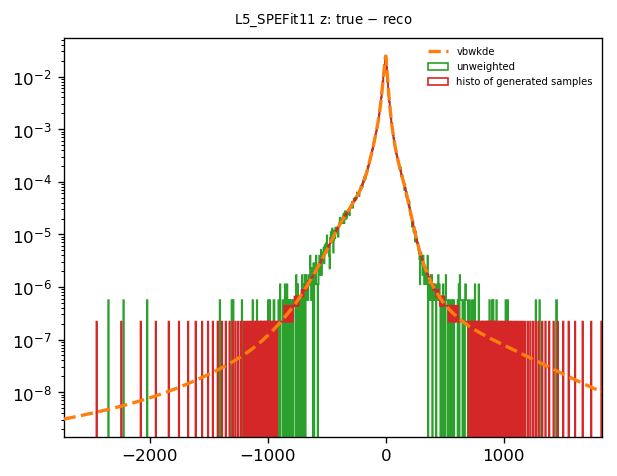

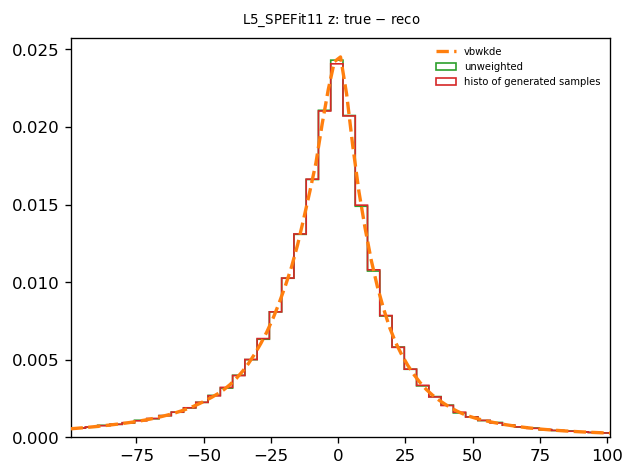

saved plots to "/home/justin/src/retro/data/priors/L5_SPEFit11_time_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/L5_SPEFit11_time_neg_error.pkl"


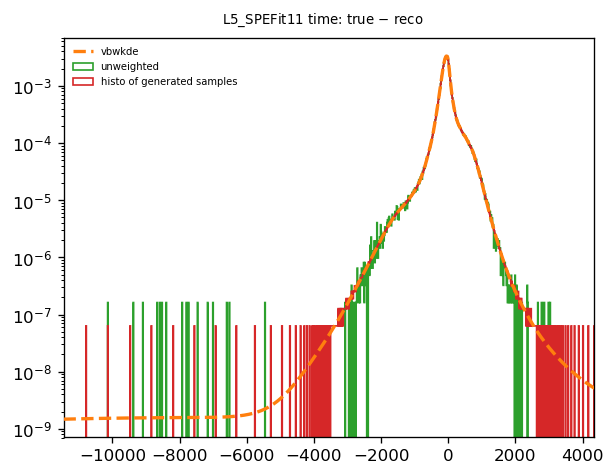

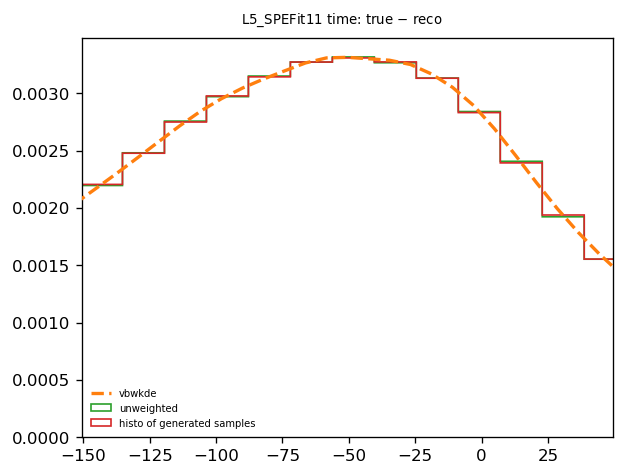

CPU times: user 1min 55s, sys: 44.7 s, total: 2min 39s
Wall time: 2min 39s


In [43]:
%%time

kwargs = dict(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='L5_SPEFit11',
    split_by_reco_param=None,
    num_split_bins=None,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=False,
    weight_tails_max_weight=None,
    mirror_about_finite_edges=True,
    num_density_samples=2000,
    n_dct=2**9,
    n_addl_iter=2,
    n_plot_bins=1000,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

spe_neg_err_dists = OrderedDict()
for param in ['x', 'y', 'z', 'time']:
    dist, axes = spe_neg_err_dists[param], axes = prior_from_reco(param=param, **kwargs)
    ax = axes[0,0]
    ax.set_yscale('log')
    plt.show()
    ax.set_yscale('linear')
    d = dist['dists'][None]
    x, pdf = d['x'], d['pdf']
    xmax = x[np.argmax(pdf)]
    ax.set_xlim(min(0, xmax-100), max(0, xmax+100))
    fig = ax.get_figure()
    display(fig)

## LineFit_DC x, y, z, and time

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_x_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_x_neg_error.pkl"


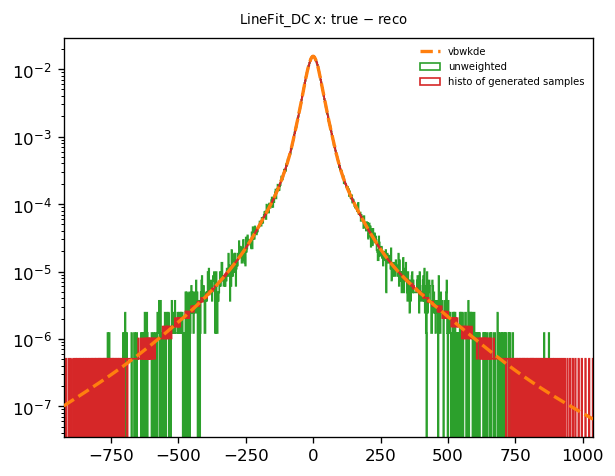

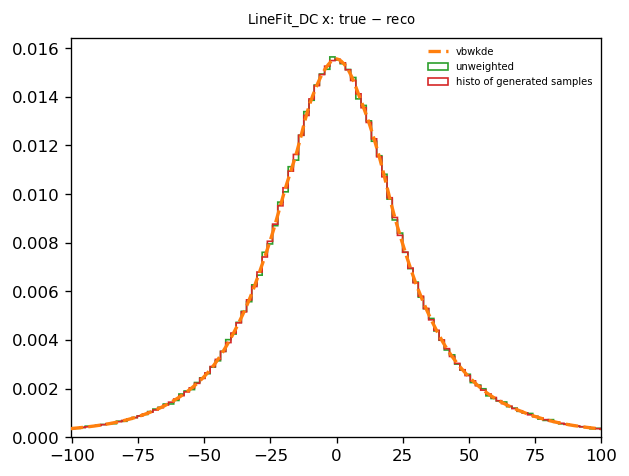

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_y_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_y_neg_error.pkl"


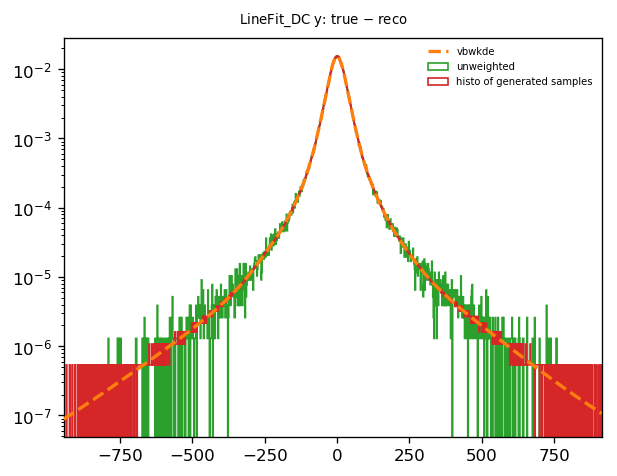

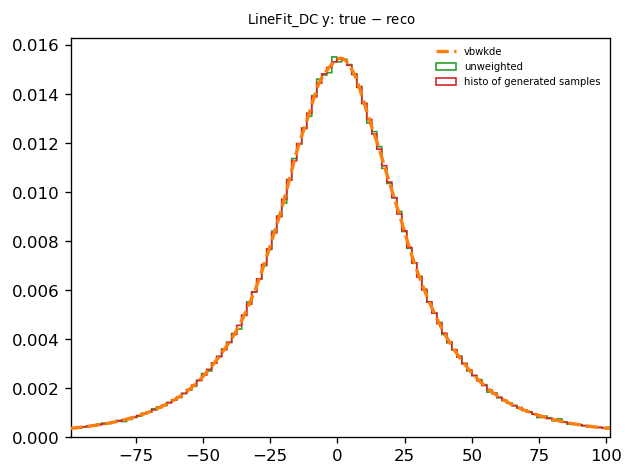

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_z_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_z_neg_error.pkl"


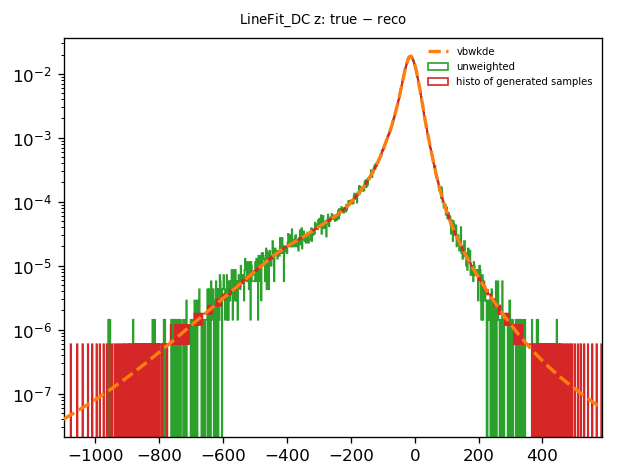

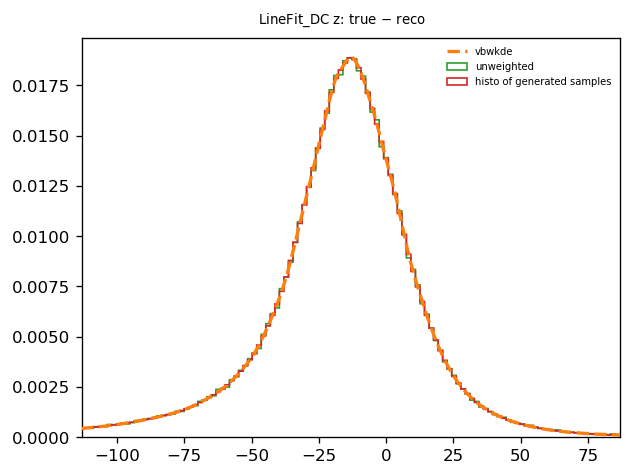

saved plots to "/home/justin/src/retro/data/priors/LineFit_DC_time_neg_error.{png, pdf}"
saved neg err dist(s) to "/home/justin/src/retro/data/priors/LineFit_DC_time_neg_error.pkl"


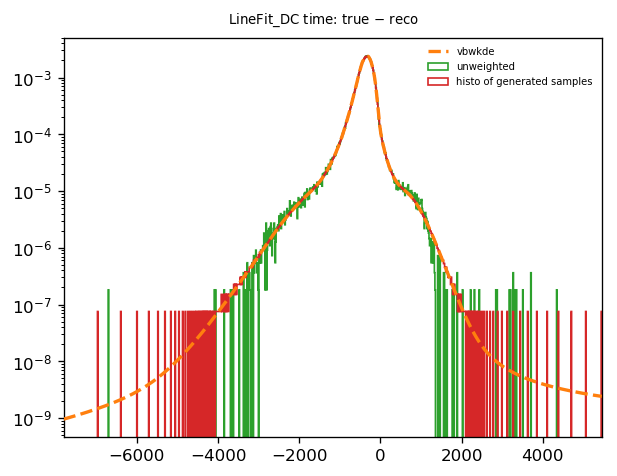

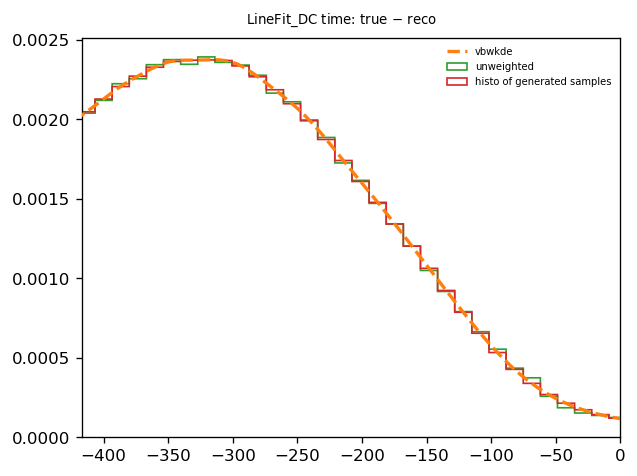

CPU times: user 2min 7s, sys: 50.9 s, total: 2min 58s
Wall time: 2min 58s


In [44]:
%%time

kwargs = dict(
    reco_array=recos,
    true_array=truth,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='LineFit_DC',
    split_by_reco_param=None,
    num_split_bins=None,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=False,
    weight_tails_max_weight=None,
    mirror_about_finite_edges=True,
    num_density_samples=2000,
    n_dct=2**9,
    n_addl_iter=2,
    n_plot_bins=1000,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

linefit_neg_err_dists = OrderedDict()
for param in ['x', 'y', 'z', 'time']:
    (linefit_neg_err_dists[param], axes) = (dist, axes) = prior_from_reco(param=param, **kwargs)
    ax = axes[0,0]
    ax.set_yscale('log')
    plt.show()
    ax.set_yscale('linear')
    d = dist['dists'][None]
    x, pdf = d['x'], d['pdf']
    xmax = x[np.argmax(pdf)]
    ax.set_xlim(min(0, xmax-100), max(0, xmax+100))
    fig = ax.get_figure()
    display(fig)

# Retro CRS

I.e., `crs_prefit` which is the first step of `crs_prefit_mn`

In [52]:
evts = pickle.load(open('/home/justin/retro_results/recos/2019-03-13.oscnext_l5_v1.priors_xyztzenaz_optimal_lowerstd/reconstructed_events.pkl'))

In [53]:
len(evts)

531668

In [58]:
evts.dtypes['Crosssection']

dtype('float64')

In [62]:
field = 'Crosssection'
dtype = np.dtype([(field, evts.dtypes[field])])
np.array(evts[field].values, dtype=dtype)

array([(5.12244303e-10,), (2.13966977e-09,), (7.06580627e-10,), ...,
       (8.89581575e-10,), (2.62282618e-09,), (1.51185231e-09,)],
      dtype=[('Crosssection', '<f8')])

In [72]:
fields = ['Crosssection', 'track_pdg']
dtype = np.dtype([(field, evts.dtypes[field]) for field in fields])
a = np.array(evts[field].values, dtype=dtype)

In [74]:
s = 'xyzzz'

In [75]:
s.replace('xyz', 'ab')

'abzz'

In [73]:
a['x']

ValueError: no field of name x

In [71]:
evts['coszen']

0         0.294727
1         0.488208
2        -0.652863
3        -0.331614
4        -0.223776
5        -0.982592
6         0.076322
7         0.792766
8        -0.340507
9        -0.843843
10       -0.942840
11        0.038891
12       -0.289409
13       -0.256355
14        0.802180
15       -0.678633
16        0.537922
17       -0.297021
18        0.066219
19        0.662237
20        0.107117
21       -0.743052
22       -0.186586
23       -0.805275
24        0.214586
25        0.712337
26       -0.602599
27       -0.370100
28        0.089337
29       -0.161623
            ...   
531638    0.062495
531639   -0.697803
531640   -0.799057
531641    0.406489
531642    0.453703
531643   -0.155292
531644    0.071400
531645    0.393358
531646   -0.609649
531647   -0.706712
531648   -0.366584
531649    0.779781
531650    0.535380
531651   -0.790200
531652   -0.845460
531653    0.266894
531654    0.003842
531655    0.254641
531656    0.325398
531657   -0.855410
531658    0.233489
531659   -0.

IndexError: too many indices for array

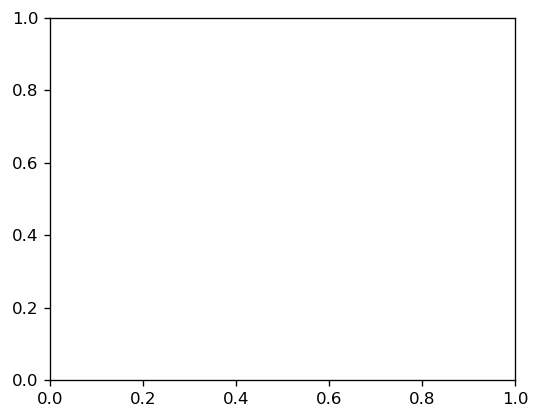

In [77]:
#%%time

kwargs = dict(
    reco_array=evts,
    true_array=evts,
    mc_version='oscnext_l5_v1 nuall+nuallbar',
    reco='retro_pft',
    split_by_reco_param=None,
    num_split_bins=None,
    use_flux_weights=False,
    deweight_by_true_params=None,
    weight_tails=False,
    weight_tails_max_weight=None,
    mirror_about_finite_edges=True,
    num_density_samples=2000,
    n_dct=2**9,
    n_addl_iter=0,
    n_plot_bins=1000,
    outdir=join(RETRO_DIR, 'data', 'priors'),
)

linefit_neg_err_dists = OrderedDict()
for param in ['x', 'y', 'z', 'time']:
    (linefit_neg_err_dists[param], axes) = (dist, axes) = prior_from_reco(param=param, **kwargs)
    ax = axes[0,0]
    ax.set_yscale('log')
    plt.show()
    ax.set_yscale('linear')
    d = dist['dists'][None]
    x, pdf = d['x'], d['pdf']
    xmax = x[np.argmax(pdf)]
    ax.set_xlim(min(0, xmax-100), max(0, xmax+100))
    fig = ax.get_figure()
    display(fig)
    break